# Final Project - Team 1 (Fall 2019) - Click Through Rate Prediction

## Team Members: 
- Apik Zorian (Section 1)
- Daniel Alvarez (Section 5)
- Sam Tosaria (Section 1)
- Shane Andrade (Section 1)

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Discussion of Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Application of Course Concepts

# Section 1. Question Formulation

## Goal of analysis

The goal of the analysis is to predict click-through rates (CTR) using the Criteo advertising data provided from the Kaggle data competition. CTR is the number of clicks that an advertisement receives divided by the number of times the advertisement is shown. CTR prediction is important for online advertisers as it can help advertisers determine the ranking of listings to given users for their query searches. Listings ranked higher on query searches are better able to get user attention, leading to more potential spending. Therefore, accurate CTR prediction enables advertisers to effectively show the right advertisement to the right user at the right time. We look to predict CTR on the Criteo data using feature engineering and modeling techniques learned through this course.

We use logistic regression and random forest algorithm approaches to minimize log loss. As mentioned in the reference paper, Aryafar, et al. (2017), log loss is often used as an indicator for model performance in online advertising. Minimizing log loss indicates that the conditional probability of clicking on an ad given a query by the user should converge to the expected click rate By minimizing log loss, we attempted to achieve convergence of the conditional probability of a click occurring with a query being issued by a user on a given advertisement listing. In the dataset 25% of the data is the predicted class. A model would improve on guessing the same class for all outcomes; we aim to train a model that will have precision and recall higher than 25%.

reference: https://arxiv.org/pdf/1711.01377.pdf

## Research and engineering questions to answer with analysis

- What are effective modeling approaches to predict click through rates?
- Why is log loss an appropriate criteria to evaluate effectiveness in predicting click through rates?
- How does our exploratory data analysis connect to transformation decisions made on the features?
- What features have most predictive power on click through rates?
- What evaluation performance is required to be achieved by a given model for it to be practically useful?
- Beyond performance on evaluation measures, what makes the choice of a model practically useful?

### Load libraries and configurations necessary for subsequent algorithm explanation and exploratory data analysis

In [5]:
# General tools & operations libraries
import re
import ast
import time
import csv
import itertools
import math
from statsmodels.stats.stattools import durbin_watson

# Mathematical operations and dataframes libraries
import numpy as np
import pandas as pd

# Plotting and visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# install pyarrow - this just needs to be performed once
! pip install pyarrow

In [3]:
# Parquet libraries
import pyarrow as pa
import pyarrow.parquet as pq

# PySpark libraries
from pyspark.sql import SQLContext
#from pyspark.sql import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.conf import SparkConf

from pyspark.sql.functions import lit, when, col, approx_count_distinct, mean, log, udf
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, OneHotEncoder, OneHotEncoderEstimator, VectorAssembler, FeatureHasher

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

Set Spark parameters and start session configurations

In [6]:
app_name = "final_project"
master = "local[*]"

conf=SparkConf()
conf.set("spark.sql.parquet.compression.codec", "snappy")

In [7]:
# start Spark Session
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [8]:
# Spark configuration Information
for object in sc.getConf().getAll():
    print(object)

('spark.app.name', 'final_project')
('spark.rdd.compress', 'True')
('spark.serializer.objectStreamReset', '100')
('spark.master', 'local[*]')
('spark.driver.port', '39313')
('spark.executor.id', 'driver')
('spark.submit.deployMode', 'client')
('spark.app.id', 'local-1576102678365')
('spark.ui.showConsoleProgress', 'true')
('spark.driver.host', 'docker.w261')


In [9]:
spark

### Note about the dataset

The datasets for the Kaggle Display Advertising Competition are downloaded from the Criteo Labs competition site and are hosted as a compressed `.tar` file in an `S3` bucket here:
https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz

The full raw `train.txt` dataset is 11.15GB in size and is too large to read into conventional Jupyter Notebooks to perform analysis. Moreover, as we will discuss later, there are significant dimensionality constraints that inhibit loading the entire dataset and performing conventional one-hot encoding on the entire dataset. A solution is required to analyze the data and perform an algorithm implementation at scale.

Therefore, we load a random sample of the dataset representing just 0.1% of the dataset. While this represents a small portion of the entire raw dataset, we believe this gives us a representative sample that will allow us to understand the dataset's features, data structure and distributions in preparation for an analysis and predictive modeling at scale.

#### Load a representative sample of the data

The following command line snippet is shown for exposition as to how we took a 0.1% random sample. This data is 11.4MB in size. It is commented out since it was just needed to produce the toy example one time. 

In [14]:
#!gzip -cd data/dac.tar.gz | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .001) print $0}' > data/sample.txt
#!cat train.txt | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .001) print $0}' > data/sample.txt

Next, we inspect the sample .`txt` data. We note that there are 46,048 lines in the dataset.

In [17]:
# check number of lines, byte and characters count
!wc data/sample.txt

wc: data/sample.txt: No such file or directory


In [16]:
# inspect first line to get a sense of the overall schema
!head -n 1 data/sample.txt

0	1	2	2	2	292	2	1	2	2	1	1		2	05db9164	0a519c5c	b00d1501	d16679b9	25c83c98	7e0ccccf	1683df22	0b153874	a73ee510	3b08e48b	89073265	e0d76380	8b266858	b28479f6	b760dcb7	1203a270	d4bb7bd8	2efa89c6			73d06dde		3a171ecb	aee52b6f		


Next, we impose a schema structure over the 40 variables. We note that:

- feature in position 0 is the target label, `y`
- feature in the 13th position is numeric (`n13`)
- features in the 14th through 39th position are categorical

In [12]:
# the 13th variable is a numeric (`n13`), 14th variable is categorical (`cat14`)
schema = StructType([
    StructField('y', IntegerType()), StructField('n1', IntegerType()),
    StructField('n2', IntegerType()), StructField('n3', IntegerType()),
    StructField('n4', IntegerType()), StructField('n5', LongType()),
    StructField('n6', IntegerType()), StructField('n7', IntegerType()),
    StructField('n8', IntegerType()), StructField('n9', IntegerType()),
    StructField('n10', IntegerType()), StructField('n11', IntegerType()),
    StructField('n12', IntegerType()), StructField('n13', IntegerType()), 
    StructField('cat14', StringType()), StructField('cat15', StringType()),
    StructField('cat16', StringType()), StructField('cat17', StringType()),
    StructField('cat18', StringType()), StructField('cat19', StringType()),
    StructField('cat20', StringType()), StructField('cat21', StringType()),
    StructField('cat22', StringType()), StructField('cat23', StringType()),
    StructField('cat24', StringType()), StructField('cat25', StringType()),
    StructField('cat26', StringType()), StructField('cat27', StringType()),
    StructField('cat28', StringType()), StructField('cat29', StringType()),
    StructField('cat30', StringType()), StructField('cat31', StringType()),
    StructField('cat32', StringType()), StructField('cat33', StringType()),
    StructField('cat34', StringType()), StructField('cat35', StringType()),
    StructField('cat36', StringType()), StructField('cat37', StringType()),
    StructField('cat38', StringType()), StructField('cat39', StringType()),
])

Next, we create Spark dataframe from the sample `.txt` file using the imposed schema structure

In [13]:
start = time.time()
print('Creating dataframe..')
df = spark.read.load("data/sample.txt", format='csv', sep='\t', header='false', schema=schema)
#df = spark.read.load(INPUT_FILES, format='csv', sep='\t', header='false', schema=schema)
print(f"... completed job in {time.time() - start} seconds")

Creating dataframe..
... completed job in 4.276499509811401 seconds


Inspect the Spark dataframe by showing the first 5 rows of selected columns. Then count the number of rows to observe that it matches the sample `.txt` file.

In [14]:
print(df.select('y','n1','n12','n13','cat14','cat39').show(n=5))

+---+----+----+---+--------+--------+
|  y|  n1| n12|n13|   cat14|   cat39|
+---+----+----+---+--------+--------+
|  0|   1|null|  2|05db9164|    null|
|  0|null|null|  1|05db9164|553d46e8|
|  0|   1|null|  2|be589b51|64f08cc6|
|  0|   0|null|  9|05db9164|    null|
|  0|   0|   0| 24|05db9164|    null|
+---+----+----+---+--------+--------+
only showing top 5 rows

None


In [15]:
# Count the number of rows
df.count()

46048

#### Write dataframe to parquet file format

In [16]:
start = time.time()
print('Writing dataframe to parquet format..')

df.write.parquet('data/df.parquet', compression='snappy', mode='overwrite')
#df.write.parquet(OUT_FILES, compression='snappy', mode='overwrite')

print(f"... completed job in {time.time() - start} seconds")

Writing dataframe to parquet format..
... completed job in 3.3757736682891846 seconds


#### 

#### Read in parquet files

In [17]:
df_pq = spark.read.load('data/df.parquet')

In [18]:
# count the number of rows
print(df_pq.count())

# perform an assert to check number of rows matches before and after parquet conversion
print(df_pq.count() == df.count())

46048
True


View parquet partition files

In [11]:
!ls -lR data/df.parquet

data/df.parquet:
total 3628
-rw-r--r-- 1 root root       0 Dec 10 17:30 _SUCCESS
-rw-r--r-- 1 root root 1371666 Dec 10 17:30 part-00000-25f01fdb-c7ec-422e-ac42-12e6176d265e-c000.snappy.parquet
-rw-r--r-- 1 root root 1372325 Dec 10 17:30 part-00001-25f01fdb-c7ec-422e-ac42-12e6176d265e-c000.snappy.parquet
-rw-r--r-- 1 root root  965266 Dec 10 17:30 part-00002-25f01fdb-c7ec-422e-ac42-12e6176d265e-c000.snappy.parquet


Check the metadata of each parquet partition

In [12]:
partitions = ['data/df.parquet/part-00000-25f01fdb-c7ec-422e-ac42-12e6176d265e-c000.snappy.parquet', 
             'data/df.parquet/part-00001-25f01fdb-c7ec-422e-ac42-12e6176d265e-c000.snappy.parquet',
             'data/df.parquet/part-00002-25f01fdb-c7ec-422e-ac42-12e6176d265e-c000.snappy.parquet']

In [13]:
for file in partitions:
    pqfile = pq.ParquetFile(file)
    print(pqfile.metadata)

  created_by: parquet-mr version 1.10.1 (build a89df8f9932b6ef6633d06069e50c9b7970bebd1)
  num_columns: 40
  num_rows: 17247
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 6563
  created_by: parquet-mr version 1.10.1 (build a89df8f9932b6ef6633d06069e50c9b7970bebd1)
  num_columns: 40
  num_rows: 17257
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 6563
  created_by: parquet-mr version 1.10.1 (build a89df8f9932b6ef6633d06069e50c9b7970bebd1)
  num_columns: 40
  num_rows: 11544
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 6530


#### Read a parquet file as a pandas dataframe

For subsequent analysis on the algorithm explanation (Section 2) and EDA (Section 3) we will use the dataframe created from a parquet partition.

In [10]:
df_sample = pd.read_parquet('data/df.parquet/part-00000-25f01fdb-c7ec-422e-ac42-12e6176d265e-c000.snappy.parquet', engine='pyarrow')

Inspect dataframe

In [16]:
df_sample.head()

,y,n1,n2,n3,n4,n5,n6,n7,n8,n9,...,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39
0,0,1.0,2,2.0,2.0,292.0,2.0,1.0,2.0,2.0,...,d4bb7bd8,2efa89c6,None,None,73d06dde,None,3a171ecb,aee52b6f,None,None
1,0,NaN,-1,86.0,1.0,6147.0,875.0,3.0,1.0,96.0,...,e5ba7672,47e4d79e,9437f62f,a458ea53,d2bc432c,None,bcdee96c,b0a08858,c9f3bea7,553d46e8
2,0,1.0,1,16.0,2.0,0.0,2.0,24.0,2.0,13.0,...,e5ba7672,e88ffc9d,efa3470f,b1252a9d,65229b6e,None,bcdee96c,3fdb382b,cb079c2d,64f08cc6
3,0,0.0,1,3.0,9.0,3195.0,57.0,3.0,35.0,120.0,...,e5ba7672,9dde83ca,None,None,831d5286,None,32c7478e,9e9a60e4,None,None
4,0,0.0,21,5.0,6.0,7460.0,192.0,2.0,24.0,153.0,...,07c540c4,7b49e3d2,None,None,73d06dde,None,3a171ecb,aee52b6f,None,None


In [17]:
df_sample.tail()

,y,n1,n2,n3,n4,n5,n6,n7,n8,n9,...,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39
17242,1,NaN,47,3.0,NaN,4692.0,183.0,26.0,1.0,107.0,...,e5ba7672,29b0e3e5,None,None,2b81e06c,None,3a171ecb,2f647dfe,None,None
17243,1,2.0,2637,5.0,3.0,4.0,0.0,9.0,19.0,124.0,...,e5ba7672,561cabfe,21ddcdc9,5840adea,efc3fe04,ad3062eb,423fab69,9b18ad04,7a402766,bde2bc96
17244,1,17.0,20,27.0,28.0,33.0,26.0,142.0,46.0,73.0,...,e5ba7672,744ad4a0,None,None,a17a10b3,None,55dd3565,e5fca70a,None,None
17245,1,45.0,12,23.0,9.0,128.0,10.0,290.0,31.0,152.0,...,e5ba7672,5bb2ec8e,55dd3565,b1252a9d,f535a39b,ad3062eb,32c7478e,b8bf466e,f0f449dd,cc963563
17246,0,3.0,-1,NaN,NaN,501.0,102.0,3.0,43.0,73.0,...,3486227d,e5f8f18f,None,None,f3ddd519,None,32c7478e,b34f3128,None,None


# Section 2. Algorithm Explanation

Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithm that you will perform.

#### Note on the toy dataset 
For the algorithm exposition in this section, we use the feature engineered "clean" toy dataset after the feature engineering/processing steps in section 4 (Algorithm Implementation). For specific details on the choices made in feature engineering, reference the transformation processing done in section 4.

## 2.1 Logistic Regression Exposition

Include toy example here and use this to explain the logistic regression model...

For this exercise, we will perform Logistic Regression. Logistic regression is appropriate since we are predicting a categorical target outcome given a feature set, $X$. <br>
A simple log transformation of the dependent variable will give an unbounded solution, thus we need to use the odds ratio to reduce the solution space to between [0,1].

Following ISL, section 4.3, we can express the logistic function for the log-odds ratio or logit for the multiple predictor case as:

$\begin{equation}log\left(\frac{p(X)}{1-p(X)}\right) = \beta_{0} + \beta_{1} X_{1} +\ldots + \beta_{p} X_{p}\end{equation}$

where $X=(X_{1},\ldots,X_{p})$ are $p$ predictors.

Therefore, the logit regression model is linear in $X$. The logistic function can be written as the logit function or an affine transformation (a), which expresses the underlying sigmoid function:

$\begin{equation}p(X)=\frac{exp^{\beta_{0} + \beta_{1}X_{1} + \ldots +\beta_{p}X_{p}}}{1+ exp^{\beta_{0} + \beta_{1}X_{1} + \ldots +\beta_{p}X_{p}}}\end{equation}$
<br>

or, alternatively, as 
$\begin{equation} z_{i} = Wx_{i}a_{i} = \sigma (z_{i})\end{equation}$ <br>


$\begin{equation}logistic(\boldsymbol{w}^T\cdot\mathbf{X}) = logit^{-1}(\boldsymbol{w}^T\cdot\mathbf{X}) = \frac{1}{1+exp^{-\boldsymbol{w}^T\cdot\mathbf{X}'_i}}\end{equation}$

where  $\boldsymbol{w}$  denotes the model parameters and $b$ represents the bias.

The Logistic Regression loss function can be described mathematically as:

$\begin{equation}
f(\boldsymbol{w}) = \sum_{i=1}^{n}log(1+exp^{-y(\boldsymbol{w}^T\cdot\mathbf{x}'_i + b)})\end{equation}$

Or, loss (L)<br>

$\begin{equation}L = \frac{1}{2N} \sum_{i}(y_{i} - a_{i})^2\end{equation}$
<br>

Using chain rule we can reduce this to : <br>

$\begin{equation}\frac{dL}{dW} = \frac{1}{N} \sum_{i}-(y_{i} - a_{i}).a_{i}(1-a_{i}).x_{i}\end{equation}$


### 2.1.1 Logistic Regression - Toy Example

First we will create a test and train toy dataset and display the train dataset.

The key characteristics of the full dataset which we have incorporated in the toy dataset:
    1. Binary classification of prediction variable.
    2. One ordinal numerical variable.
    3. Two string categorical variables.
    4. Missing data
    5. Unseen variables in the test dataset

In [119]:
%%capture --no-display
#Total number of obersvations
N = 20
# Dimensions - for creating weight vector (1,2,3,4,a,b,c,d,x,y)
D = 10

def create_toy_dataset(n_rows, dimensions, convert_ordinal=True, rand_seed=52):
    np.random.seed(rand_seed)
    
    # Create a TRAIN dataset
    train = pd.DataFrame()

    # Create three variables  
    # Variable 1 - Numerical ordinal -- 1 to 4
    ordinal_data = np.repeat(np.array([1,2,3,4]), 5)

    # Variable 2, 3 - string categorial variables
    cat_data_1 = np.tile(np.array(['a', 'b', 'c', 'd']), int(N/4))
    cat_data_2 = np.tile(np.array(['x', 'y']), int(N/2))

    # Create the dependent variable, zeros for first ten values and ones for the next ten values
    # For simplicity, the ordinal variables 1,2 and associated with the outcome variable 0
    #  3,4 are associated with the outcome label 1
    y = np.repeat(np.array([0, 1]), 10)

    #Add variables to the dataframe
    train['y'] = y
    train['o1'] = ordinal_data
    train['c2'] = cat_data_1
    train['c3'] = cat_data_2

    if convert_ordinal:
        #Force numerical variable to a categorical variable so nummy variables are created using pandas
        train['o1'] = train['o1'].astype('category')

    #Introduce missing data
    train['c2'][0] = ""
    train['c2'][5] = ""
    train['c2'][10] = ""
    train['c2'][15] = ""

    # Create TEST dataset
    test = pd.DataFrame()

    # Create three variables  
    # Variable 1 - Numerical ordinal WITH a new unseen variable ('0')
    ordinal_data = np.repeat(np.array([100,2,3,4]), 5)

    # Variable 2, 3 - string categorial variables
    cat_data_1 = np.tile(np.array(['a', 'b', 'c', 'd']), int(N/4))
    cat_data_2 = np.tile(np.array(['x', 'y']), int(N/2))

    # Create a y labels variable and insert them into the dataset
    test['y'] = np.repeat(np.array([0, 1]), 10)
    test['o1'] = ordinal_data
    test['c2'] = cat_data_1
    test['c3'] = cat_data_2

    if convert_ordinal:
        test['o1'] = test['o1'].astype('category')
    
    return train, test

df, df_test = create_toy_dataset(N, D)
df

,y,o1,c2,c3
0,0,1,,x
1,0,1,b,y
2,0,1,c,x
3,0,1,d,y
4,0,1,a,x
5,0,2,,y
6,0,2,c,x
7,0,2,d,y
8,0,2,a,x
9,0,2,b,y


### 2.1.2 Dummy Variable Behavior in pySpark MLlib and Pandas
When creating dummy variables, to avoid multicollinearity between a variable and the intercept, one variable is dropped. 
The default behavior in the `Pandas` package with regards to final dummy variable exclusion is different from the `Spark.MLlib` package. <br>
The `Spark.MLlib` package creates a missing value dummy variable as a seperate dummy subclass for each of the variables and `dropLast` parameter on the `OneHotEncoderEstimator` class drops all the 'null' subclasses. To recreate the equivalent in the `Pandas/numpy` package we are dropping the 'c2_' column, which is the one-hot encoded variable for the missing values.


In [105]:
X = pd.get_dummies(df.drop(columns=['y']))
X.head()
#Drop a variable to avoid multicollinearity
X.drop(columns=['c2_'], axis=1, inplace=True)

y = pd.DataFrame(df.y)
y = y.astype('int')
y.shape

(20, 1)

In [106]:
X.head(n=10)

,o1_1,o1_2,o1_3,o1_4,c2_a,c2_b,c2_c,c2_d,c3_x,c3_y
0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,1
2,1,0,0,0,0,0,1,0,1,0
3,1,0,0,0,0,0,0,1,0,1
4,1,0,0,0,1,0,0,0,1,0
5,0,1,0,0,0,0,0,0,0,1
6,0,1,0,0,0,0,1,0,1,0
7,0,1,0,0,0,0,0,1,0,1
8,0,1,0,0,1,0,0,0,1,0
9,0,1,0,0,0,1,0,0,0,1


Here, we define functions for the sigmoid function, the derivative of the loss function and gradient descent.

In [107]:
def sigmoid(z):
    """apply affine transformation to the 
    coefficient and independent variables
    """
    return 1/(1 + np.exp(-z))

def get_derivative(x, e, a):
    """apply loss function 
    Input: 
            independent variables observations (x),
            error= (y - prediction),
            affine transformation (a)
    Output:
            vector of size weight vector
    """
    return - x.T.dot(e * a *(1 - a))

def grad_desc(X, y, steps = 10, batch = 1, lr = 0.9, verbose = True):
    """ Input: 
                Independent variable observations (X), 
                labels (y), number of iterations (steps), 
                batch size (batch) and learning rate (lr)
        Output: 
                List of weights for each step(params)
    """
    batch_updates = int(len(X)/batch)
    np.random.seed(12)
    w = np.random.randn(D, 1)
    
    param = []
    loss = np.zeros((steps,))
    
    for step in range(steps):
        indx = list(np.random.choice(len(X), batch, replace = False))

        X_batch = np.array(X.iloc[indx,])
        y_batch = np.array(y.iloc[indx,])
        
        
        for batch in range(batch_updates):
            a = sigmoid(X_batch.dot(w))
            e = y_batch - a
            w = w - lr * get_derivative(X_batch, e, a)
        
        loss[step] = 0.5 * e.T.dot(e) / len(e)
        param.append(w)
        if verbose:
            print(f'Step - {step} --- loss - {loss[step]}')
    return param, loss

param, loss = grad_desc(X, y)
print('\n Coefficient weights - \n')
print(param[-1])


Step - 0 --- loss - 0.03174810518336583
Step - 1 --- loss - 0.0041214409362725695
Step - 2 --- loss - 0.0018025514284518713
Step - 3 --- loss - 0.0011280263927289837
Step - 4 --- loss - 0.0008216757927381938
Step - 5 --- loss - 0.0006593564537874984
Step - 6 --- loss - 0.0005544411528644965
Step - 7 --- loss - 0.0004503242791715662
Step - 8 --- loss - 0.00040838315105599666
Step - 9 --- loss - 0.00035967442948333696

 Coefficient weights - 

[[-4.03428538]
 [-4.43969704]
 [ 3.16416284]
 [ 2.998458  ]
 [ 0.51039821]
 [-0.84348923]
 [ 0.48208578]
 [-0.88557402]
 [ 0.11147867]
 [ 1.30873345]]


In [120]:
#save the TRAIN and TEST data
df.to_csv('data/toy_data.csv', sep = '\t', na_rep='null', header=False, index=False)
df_test.to_csv('data/toy_test_data.csv', sep = '\t', na_rep='null', header=False, index=False)

### 2.1.3 Recreating the Solution in pySpark
The matrix form solution logistic regression solution implemented in numpy above will not scale well on a large set of feature variables. Thus we need to implement a sparse representation of the one hot encoded rows.


### From One-hot-encoded Matrix to Sparse Vectors
The first row of the matrix looks like this:<br>

                    [1 	0 	0 	0 	0 	0 	0 	0 	1 	0]

We can reduce this representation to a sparse vector containing:

    [['Length of vector'], ['List of indices containing values'], ['List of corresponding values']]

                                [10,  [0,  8], [1.0,  1.0] 
Note: The index number difference between the matrix representation and the Spark implementation is due to the ordering of the ordinal variable, the `Pandas.get_dummies()` assigns dummy variables in acending order, Spark does not.


In Spark we can get this sparse representation using a three step pipeline using a stringindexer to convert the string categorical variables to a numerical categorical variable, next the one hot encoder creates a sparse representation of each feature set in the format shown above and finally the vector assembler merges the various lists into a single list representation of a row.



In [129]:
#global variables declaration
MAX_ITER = 10
EPSILON = 1e-16

In [130]:
def load_pyspark_dataframes():
    #Specify the schema on read
    schema = StructType([
        StructField('y', IntegerType()),
        StructField('o1', IntegerType()),
        StructField('cat2', StringType()),
        StructField('cat3', StringType())
        ])
    #Load the data in Spark dataframes
    df = spark.read.load('data/toy_data.csv', 
                           format='csv', sep= '\t', 
                           header='false', 
                           schema=schema)


    df_test = spark.read.load('data/toy_test_data.csv', 
                               format='csv', sep= '\t', 
                               header='false', 
                               schema=schema, 
                               mode='FAILFAST')
    
    return df, df_test

df, df_test = load_pyspark_dataframes()
df.show()

+---+---+----+----+
|  y| o1|cat2|cat3|
+---+---+----+----+
|  0|  1|null|   x|
|  0|  1|   b|   y|
|  0|  1|   c|   x|
|  0|  1|   d|   y|
|  0|  1|   a|   x|
|  0|  2|null|   y|
|  0|  2|   c|   x|
|  0|  2|   d|   y|
|  0|  2|   a|   x|
|  0|  2|   b|   y|
|  1|  3|null|   x|
|  1|  3|   d|   y|
|  1|  3|   a|   x|
|  1|  3|   b|   y|
|  1|  3|   c|   x|
|  1|  4|null|   y|
|  1|  4|   a|   x|
|  1|  4|   b|   y|
|  1|  4|   c|   x|
|  1|  4|   d|   y|
+---+---+----+----+



In [131]:
#specify columns to turn from string categorical variables to numerical categorical representation
cat_cols = [ 'o1', 'cat2', 'cat3']

indexers = [StringIndexer(inputCol= c, 
                         outputCol="{0}_Indx".format(c), 
                         handleInvalid="keep") 
           for c in cat_cols]


#create a pipeline to add the additional steps
pipeline = Pipeline(stages = indexers) 
model = pipeline.fit(df)
transformed = model.transform(df)

transformed.show()

+---+---+----+----+-------+---------+---------+
|  y| o1|cat2|cat3|o1_Indx|cat2_Indx|cat3_Indx|
+---+---+----+----+-------+---------+---------+
|  0|  1|null|   x|    3.0|      4.0|      0.0|
|  0|  1|   b|   y|    3.0|      2.0|      1.0|
|  0|  1|   c|   x|    3.0|      3.0|      0.0|
|  0|  1|   d|   y|    3.0|      0.0|      1.0|
|  0|  1|   a|   x|    3.0|      1.0|      0.0|
|  0|  2|null|   y|    1.0|      4.0|      1.0|
|  0|  2|   c|   x|    1.0|      3.0|      0.0|
|  0|  2|   d|   y|    1.0|      0.0|      1.0|
|  0|  2|   a|   x|    1.0|      1.0|      0.0|
|  0|  2|   b|   y|    1.0|      2.0|      1.0|
|  1|  3|null|   x|    2.0|      4.0|      0.0|
|  1|  3|   d|   y|    2.0|      0.0|      1.0|
|  1|  3|   a|   x|    2.0|      1.0|      0.0|
|  1|  3|   b|   y|    2.0|      2.0|      1.0|
|  1|  3|   c|   x|    2.0|      3.0|      0.0|
|  1|  4|null|   y|    0.0|      4.0|      1.0|
|  1|  4|   a|   x|    0.0|      1.0|      0.0|
|  1|  4|   b|   y|    0.0|      2.0|   

In [132]:
cat_cols = [ 'o1', 'cat2', 'cat3']
cat_vecs = [ 'o1v', 'cat2v', 'cat3v']
indexers = [StringIndexer(inputCol= c, 
                         outputCol="{0}_Indx".format(c), 
                         handleInvalid="keep") 
           for c in cat_cols]
#Create a list representation of the numerical categorical representation
encoder = OneHotEncoderEstimator(inputCols = [indexer.getOutputCol() for indexer in indexers], 
                                  outputCols = cat_vecs, 
                                  dropLast = True)
#adding a assembler step which creates a sparse representation of an indexed column
assembler = VectorAssembler(inputCols=encoder.getOutputCols(), 
                           outputCol = 'features')

#creating the full transform pipeline       
pipeline = Pipeline(stages = indexers + [encoder] + [assembler] )

model = pipeline.fit(df)

transformed = model.transform(df)


transformed.show(truncate=True)



# Repeating the steps for the TEST dataset
indexers = [StringIndexer(inputCol= c, 
                         outputCol="{0}_Indx".format(c), 
                         handleInvalid="keep") 
           for c in cat_cols]

encoder = OneHotEncoderEstimator(inputCols = [indexer.getOutputCol() for indexer in indexers], 
                                  outputCols = cat_vecs, 
                                  dropLast = True)

assembler = VectorAssembler(inputCols=encoder.getOutputCols(), 
                           outputCol = 'features')

        
pipeline = Pipeline(stages = indexers + [encoder] + [assembler] )

test_features = pipeline.fit(df_test).transform(df_test)

+---+---+----+----+-------+---------+---------+-------------+-------------+-------------+--------------------+
|  y| o1|cat2|cat3|o1_Indx|cat2_Indx|cat3_Indx|          o1v|        cat2v|        cat3v|            features|
+---+---+----+----+-------+---------+---------+-------------+-------------+-------------+--------------------+
|  0|  1|null|   x|    3.0|      4.0|      0.0|(4,[3],[1.0])|    (4,[],[])|(2,[0],[1.0])|(10,[3,8],[1.0,1.0])|
|  0|  1|   b|   y|    3.0|      2.0|      1.0|(4,[3],[1.0])|(4,[2],[1.0])|(2,[1],[1.0])|(10,[3,6,9],[1.0,...|
|  0|  1|   c|   x|    3.0|      3.0|      0.0|(4,[3],[1.0])|(4,[3],[1.0])|(2,[0],[1.0])|(10,[3,7,8],[1.0,...|
|  0|  1|   d|   y|    3.0|      0.0|      1.0|(4,[3],[1.0])|(4,[0],[1.0])|(2,[1],[1.0])|(10,[3,4,9],[1.0,...|
|  0|  1|   a|   x|    3.0|      1.0|      0.0|(4,[3],[1.0])|(4,[1],[1.0])|(2,[0],[1.0])|(10,[3,5,8],[1.0,...|
|  0|  2|null|   y|    1.0|      4.0|      1.0|(4,[1],[1.0])|    (4,[],[])|(2,[1],[1.0])|(10,[1,9],[1.0,1.0])|
|

### 2.1.4 Hash Transformation
A hashing function can transform a set of inputs (numerical or string) variables into a feature vector of fixed length. There are a number of advantages to conducting a feature hashing. Firstly, this step can be converted with a single pass over the data without heavy computation load. Secondly, this model can deal with new or unseen variables by continuing to map out the features to the specified feature vector, thus being able to withstand the rigors of a production environment requiring quick computations and changes in feature sets. 

However, there are some disadvatages to hashing as well. Firstly, the mapping cannot be reversed, thus the practitioners cannot gain any interpretive insight into the behavior of the model. Secondly, a fixed feature vector can lead to feature collisions, when multiple input variables may be assigned to the same vector index.

Given the very large number of variables, a feature hasher can be employed to reduce the feature space, or adapted in a production environment as a reasonable abstraction of the one hot encoding output.

Returning to the toy dataset, here we are mapping the 10 variables to a fixed feature vector of length 8.

In [133]:
cat_cols = [ 'o1', 'cat2', 'cat3']

hasher = FeatureHasher(inputCols=cat_cols, outputCol="features", numFeatures = 8)

hash_transformed = hasher.transform(df)

hash_transformed.show(truncate=False)

+---+---+----+----+-------------------------+
|y  |o1 |cat2|cat3|features                 |
+---+---+----+----+-------------------------+
|0  |1  |null|x   |(8,[1,6],[1.0,1.0])      |
|0  |1  |b   |y   |(8,[0,1],[1.0,2.0])      |
|0  |1  |c   |x   |(8,[1,2,6],[1.0,1.0,1.0])|
|0  |1  |d   |y   |(8,[0,1,6],[1.0,1.0,1.0])|
|0  |1  |a   |x   |(8,[1,6,7],[1.0,1.0,1.0])|
|0  |2  |null|y   |(8,[0,1],[1.0,2.0])      |
|0  |2  |c   |x   |(8,[1,2,6],[2.0,1.0,1.0])|
|0  |2  |d   |y   |(8,[0,1,6],[1.0,2.0,1.0])|
|0  |2  |a   |x   |(8,[1,6,7],[2.0,1.0,1.0])|
|0  |2  |b   |y   |(8,[0,1],[1.0,3.0])      |
|1  |3  |null|x   |(8,[1,6],[3.0,1.0])      |
|1  |3  |d   |y   |(8,[0,1,6],[1.0,3.0,1.0])|
|1  |3  |a   |x   |(8,[1,6,7],[3.0,1.0,1.0])|
|1  |3  |b   |y   |(8,[0,1],[1.0,4.0])      |
|1  |3  |c   |x   |(8,[1,2,6],[3.0,1.0,1.0])|
|1  |4  |null|y   |(8,[0,1],[1.0,4.0])      |
|1  |4  |a   |x   |(8,[1,6,7],[4.0,1.0,1.0])|
|1  |4  |b   |y   |(8,[0,1],[1.0,5.0])      |
|1  |4  |c   |x   |(8,[1,2,6],[4.0

### 2.1.5 Evaluation Metrics

Log loss is used to evaluate logistic regression and tree-based algorithms. It is the negative log-likelihood of the Bernoulli model. As mentioned in the reference paper, Aryafar, et al. (2017), log loss is often used as an indicator for model performance in online advertising. Minimizing log loss indicates that the conditional probability of clicking on an ad given a query by the user should converge to the expected click rate. Here the conditional probability can be written an $P(c|q,l)$, where $c$ is the binary response of clicking on an advertisement or not, $q$ is the indicator for a query issued by a user and $l$ is a given advertisement listing. A model with lower log loss is preferred. This is referred to in the reference paper Aryafar, et al. (2017).

The following logarithmic loss function is used to evaluate the model proposed:

$\begin{equation}
\boldsymbol{logloss} = -\frac{1}{L}\sum_{i=1}^{L}y_{i}log p_{i}+(1-y_{i})log(1-p_{i})\end{equation}$

where $L$ is the number of instances, $y_{i} \in {0,1}$ is the label of the $i^{th}$ instance, and $p_{i}$ is the probability of that the $i^{th}$ instance is clicked. 

Calculating a negative log of the probabilities to avoid decimal point overflow, the log loss of an estimate can be calculated by

\begin{equation*}
\begin{cases}     
  y_{i}  \colon  1  =>  log(p(y_{i}))     \\
  y_{i}  \colon  0  =>  log(1 - p(y_{i}))
\end{cases}
\end{equation*}


In [134]:
mean_prob = transformed.select(mean(col('y'))).collect()[0]['avg(y)']
transformed = transformed.withColumn('calc_probability', lit(mean_prob))
transformed = transformed.withColumn('logloss', when(col('y') > 0.0, - log(col('calc_probability') + EPSILON))\
                                       .otherwise( - log(1.0 - col('calc_probability') + EPSILON)))
transformed.select(['features', 'calc_probability', 'logloss']).show()

+--------------------+----------------+------------------+
|            features|calc_probability|           logloss|
+--------------------+----------------+------------------+
|(10,[3,8],[1.0,1.0])|             0.5|0.6931471805599451|
|(10,[3,6,9],[1.0,...|             0.5|0.6931471805599451|
|(10,[3,7,8],[1.0,...|             0.5|0.6931471805599451|
|(10,[3,4,9],[1.0,...|             0.5|0.6931471805599451|
|(10,[3,5,8],[1.0,...|             0.5|0.6931471805599451|
|(10,[1,9],[1.0,1.0])|             0.5|0.6931471805599451|
|(10,[1,7,8],[1.0,...|             0.5|0.6931471805599451|
|(10,[1,4,9],[1.0,...|             0.5|0.6931471805599451|
|(10,[1,5,8],[1.0,...|             0.5|0.6931471805599451|
|(10,[1,6,9],[1.0,...|             0.5|0.6931471805599451|
|(10,[2,8],[1.0,1.0])|             0.5|0.6931471805599451|
|(10,[2,4,9],[1.0,...|             0.5|0.6931471805599451|
|(10,[2,5,8],[1.0,...|             0.5|0.6931471805599451|
|(10,[2,6,9],[1.0,...|             0.5|0.693147180559945

### 2.1.6 Logistic Regression in Spark

The batch error calculation shown in the numpy implementation above is an embarassingly parallelizable task in the Map-Reduce framework as it does not require communication with the master or the other worker nodes. In addition, the Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm appriximates the Hessian matrix, thus allowing for an at scale implementation of the logistic regression model.

The `MLlib` logistic regression implementation contains an elastic-net feature which allow a balance between L1 and L2 regularizations.

Below we are setting the number of iterations and the classification threshold.

Source: https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm

In [135]:
lr = LogisticRegression(featuresCol = 'features',
                        labelCol='y', 
                        maxIter = MAX_ITER,
                        threshold = 0.5
                        )


lr_model_basic = lr.fit(transformed)

In [136]:
def sigmoid(rawPrediction):
    #apply affine transformation
    return 1 / (1 + math.exp(- rawPrediction))

def extract_from_vector(vec, i):
    """ Input: VectorUDT data type
        Output: float type at index (i)
    """
    try:
        return float(vec[i])
    except ValueError:
        return None

#register UDFs    
get_probability = udf(sigmoid, DoubleType())
get_val = udf(extract_from_vector, DoubleType())

#Get predictions on test data
result = lr_model_basic.transform(test_features)

#Apply affine transformation to the linear regression output
result2 = result.withColumn('calc_prob', get_probability(get_val("rawPrediction", lit(1))))
# calculate log loss
result3 = result2.withColumn('logloss', when(col('y') > 0.0, - log(col('calc_prob') + EPSILON))\
                                       .otherwise( - log(1.0 - col('calc_prob') + EPSILON)))


result3.select(['o1', 'features', 'y', 'prediction','calc_prob', 'logloss']).show(truncate=False)

+---+--------------------------+---+----------+---------------------+---------------------+
|o1 |features                  |y  |prediction|calc_prob            |logloss              |
+---+--------------------------+---+----------+---------------------+---------------------+
|100|(10,[1,5,8],[1.0,1.0,1.0])|0  |0.0       |3.7594849521551885E-4|3.7601918156775124E-4|
|100|(10,[1,6,9],[1.0,1.0,1.0])|0  |0.0       |3.7594849521529886E-4|3.7601918156752914E-4|
|100|(10,[1,7,8],[1.0,1.0,1.0])|0  |0.0       |3.7594849521551885E-4|3.7601918156775124E-4|
|100|(10,[1,4,9],[1.0,1.0,1.0])|0  |0.0       |3.7594849521529886E-4|3.7601918156752914E-4|
|100|(10,[1,5,8],[1.0,1.0,1.0])|0  |0.0       |3.7594849521551885E-4|3.7601918156775124E-4|
|2  |(10,[2,6,9],[1.0,1.0,1.0])|0  |1.0       |0.9996240515046126   |7.886058404309552    |
|2  |(10,[2,7,8],[1.0,1.0,1.0])|0  |1.0       |0.9996240515046129   |7.886058404310143    |
|2  |(10,[2,4,9],[1.0,1.0,1.0])|0  |1.0       |0.9996240515046126   |7.886058404

In [62]:
#Extract feature names and indices from table metadata
features = [x["name"] for x in sorted(transformed.schema["features"].metadata["ml_attr"]["attrs"]["binary"], 
                                      key=lambda x: x["idx"]
                                     )]

In [66]:
coeff_lst = list(zip(features,lr_model_basic.coefficients))
for coeff in coeff_lst:
    print(coeff)

('o1v_4', 7.885682385303408)
('o1v_2', -7.885682385410476)
('o1v_3', 7.885682385303408)
('o1v_1', -7.885682385410433)
('cat2v_d', -5.272723327329144e-11)
('cat2v_a', -5.2483678882973996e-11)
('cat2v_b', -5.272723327329144e-11)
('cat2v_c', -5.2483678882973996e-11)
('cat3v_x', -8.011541632617964e-11)
('cat3v_y', -8.045652764483514e-11)


# 2.2 Random Forest Exposition

Random forests are an ensemble algorithm in which a number of decision trees are trained and then used for prediction in classification or regression. The decision trees are created on samples of the training data using a process called bootstrap aggregation or "bagging". Bagging works by sampling with replacement $B$ samples of size $n$ from a dataset $X$ giving datasets $X_i$ for $i \in \{1, ..., |B|\}$. Each dataset $X_i$ is used to train its own decision tree, resulting in a total of $|B|$ decision trees. During inference, each tree in the ensemble receives a copy of the input and produces its own prediction. In the case of classification, the class with the most results is the final prediction. For regression, the predictions are averaged to produce a single prediction.

#### Random Forest - Toy Example

We will use the same toy dataset above but will not drop columns as we did with logistic regression since random forests are not impacted by multicollinearity.

First we create the train and test datasets and create dummy variables for the categorical columns. We opt to not treat ordinal columns as categorical columns, but rather, to keep them as numeric types by passing `convert_ordinal=False`.

In [99]:
# create training data from dataframe
df, df_test = create_toy_dataset(N, D, convert_ordinal=False)

X = pd.get_dummies(df.drop(columns=['y']))
X.sample(5).head()

,o1,c2_,c2_a,c2_b,c2_c,c2_d,c3_x,c3_y
6,2,0,0,0,1,0,1,0
2,1,0,0,0,1,0,1,0
4,1,0,1,0,0,0,1,0
8,2,0,1,0,0,0,1,0
17,4,0,0,1,0,0,0,1


In [100]:
y = pd.DataFrame(df.y)
y = y.astype('int')
y.shape

(20, 1)

Next, we train the RandomForestClassifier using scikit-learn. For the toy example we only use 5 trees with a depth of 2. After training, we print the features in order of importance as determined by the algorithm.

In [101]:
from sklearn.ensemble import RandomForestClassifier

# train the classifier
rfc = RandomForestClassifier(max_depth=2, n_estimators=5, random_state=0)
rfc.fit(X, y)

# print importance of features in order of importance
important_features = [idx for idx in np.argsort(rfc.feature_importances_)[::-1]]
feature_names = [X.columns[idx] for idx in important_features]
importances = [rfc.feature_importances_[idx] for idx in important_features]

pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

,feature,importance
0,o1,0.814249
1,c2_d,0.078795
2,c2_b,0.073215
3,c2_c,0.033741
4,c3_y,0.000000
5,c3_x,0.000000
6,c2_a,0.000000
7,c2_,0.000000


#### Random Forest in PySpark - Toy Example

Using the same toy dataset we will train a random forest classifier using PySpark.

We begin by loading the data into PySpark dataframes.

In [104]:
df, df_test = load_pyspark_dataframes()
df.show()

+---+---+----+----+
|  y| o1|cat2|cat3|
+---+---+----+----+
|  0|  1|null|   x|
|  0|  1|   b|   y|
|  0|  1|   c|   x|
|  0|  1|   d|   y|
|  0|  1|   a|   x|
|  0|  2|null|   y|
|  0|  2|   c|   x|
|  0|  2|   d|   y|
|  0|  2|   a|   x|
|  0|  2|   b|   y|
|  1|  3|null|   x|
|  1|  3|   d|   y|
|  1|  3|   a|   x|
|  1|  3|   b|   y|
|  1|  3|   c|   x|
|  1|  4|null|   y|
|  1|  4|   a|   x|
|  1|  4|   b|   y|
|  1|  4|   c|   x|
|  1|  4|   d|   y|
+---+---+----+----+



Next, we perform one hot encoding of the categorical variables and vectorize all the resulting feature columns into a single vector column. We do this for the test and train datasets.

In [121]:
# perform transformations to one hot encode categorical features and vectorize
numeric_cols = ['o1']
cat_cols = ['cat2', 'cat3']
cat_vecs = ['cat2v', 'cat3v']

indexers = [StringIndexer(inputCol= c, 
                         outputCol="{0}_Indx".format(c), 
                         handleInvalid="keep") 
           for c in cat_cols]

encoder = OneHotEncoderEstimator(inputCols = [indexer.getOutputCol() for indexer in indexers], 
                                  outputCols = cat_vecs, 
                                  dropLast = True)

assembler = VectorAssembler(inputCols=numeric_cols + encoder.getOutputCols(), 
                           outputCol = 'features')

        
pipeline = Pipeline(stages = indexers + [encoder] + [assembler])
model = pipeline.fit(df)
transformed = model.transform(df)
transformed.show(truncate=True)

test_features = pipeline.fit(df_test).transform(df_test)

+---+---+----+----+---------+---------+-------------+-------------+--------------------+
|  y| o1|cat2|cat3|cat2_Indx|cat3_Indx|        cat2v|        cat3v|            features|
+---+---+----+----+---------+---------+-------------+-------------+--------------------+
|  0|  1|null|   x|      4.0|      0.0|    (4,[],[])|(2,[0],[1.0])| (7,[0,5],[1.0,1.0])|
|  0|  1|   b|   y|      2.0|      1.0|(4,[2],[1.0])|(2,[1],[1.0])|(7,[0,3,6],[1.0,1...|
|  0|  1|   c|   x|      3.0|      0.0|(4,[3],[1.0])|(2,[0],[1.0])|(7,[0,4,5],[1.0,1...|
|  0|  1|   d|   y|      0.0|      1.0|(4,[0],[1.0])|(2,[1],[1.0])|(7,[0,1,6],[1.0,1...|
|  0|  1|   a|   x|      1.0|      0.0|(4,[1],[1.0])|(2,[0],[1.0])|(7,[0,2,5],[1.0,1...|
|  0|  2|null|   y|      4.0|      1.0|    (4,[],[])|(2,[1],[1.0])| (7,[0,6],[2.0,1.0])|
|  0|  2|   c|   x|      3.0|      0.0|(4,[3],[1.0])|(2,[0],[1.0])|(7,[0,4,5],[2.0,1...|
|  0|  2|   d|   y|      0.0|      1.0|(4,[0],[1.0])|(2,[1],[1.0])|(7,[0,1,6],[2.0,1...|
|  0|  2|   a|   x|  

We take the vectorized dataset and train the classifier by minimizing the log loss.

In [122]:
import math
from pyspark.ml.classification import RandomForestClassifier

# define UDF for calculating log loss
def log_loss(actual, predicted, epsilon=1e-15):
    acutal = int(actual)
    predicted = predicted[0]  # class 0

    # clip value between [epsion, 1-epsilon]
    predicted = max(predicted, epsilon)
    predicted = min(predicted, 1-epsilon)

    if actual == 1:
        return -math.log(predicted)
    else:
        return -math.log(1 - predicted)
    

# register UDF
spark.udf.register('log_loss', log_loss, DoubleType())
log_loss_udf = udf(log_loss, DoubleType())

# create and train random forest
rf = RandomForestClassifier(featuresCol='features', labelCol='y', numTrees=5, maxDepth=2)
rfModel = rf.fit(transformed)
rfPredictions = rfModel.transform(test_features)
rfPredictions = rfPredictions.select('y',
                                     'prediction',
                                     'rawPrediction',
                                     'probability',
                                     log_loss_udf('y', 'probability').alias('log_loss')).\
    cache()

# display log loss
print('Log loss: ', rfPredictions.groupBy().mean('log_loss').collect()[0]['avg(log_loss)'])

Log loss:  2.3471555302466234


We then list the features in order of importance as determined by the trained classifier.

In [123]:
def list_feature_importances(importances, df, featureCol='features'):
    list_extract = []
    for i in df.schema[featureCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + df.schema[featureCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: None if x >= len(importances) else importances[x])
    
    return varlist.sort_values('score', ascending = False)

# list important features in descending order
list_feature_importances(rfModel.featureImportances, transformed)

,idx,name,score
0,0,o1,0.800000
6,6,cat3v_y,0.187325
2,2,cat2v_a,0.012675
1,1,cat2v_d,0.000000
3,3,cat2v_b,0.000000
4,4,cat2v_c,0.000000
5,5,cat3v_x,0.000000


# Section 3. EDA & Discussion of Challenges

Determine 2-3 relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable. Discuss any challenges that you anticipate based on the EDA you perform.

#### The EDA comprises the following tasks:
- Understanding the data structure and composition of the features in the dataset.
- Plotting the target and numerical variables to understand their distributions in order to make decisions about the type of transformations required. 
    - For instance, if numerical variables are ordinal in nature, performing appropriate bucketing of the variables or one-hot encoding to ensure each value is captured in the data for analysis.
- Displaying the distribution of the categorical variables to understand their distributions in order to make decision about the bucketing or one-hot encoding required.

#### Dataset subsetting

Given the large size of the raw text data (over 11GB), the `train.txt` was split into smaller representative parts. This splitting of the raw data was thought to work well to understand the characteristics of the data required for the exploratory data analysis and enable the algorithm to work at scale. For this analysis in particular, we analyzed a dataframe from a parquet partition on 0.1% random sample of the raw data.

First, we assess the data structure, data types and non-null values for each feature

In [18]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17247 entries, 0 to 17246
Data columns (total 40 columns):
y        17247 non-null int32
n1       9653 non-null float64
n2       17247 non-null int32
n3       13501 non-null float64
n4       13458 non-null float64
n5       16792 non-null float64
n6       13314 non-null float64
n7       16436 non-null float64
n8       17233 non-null float64
n9       16436 non-null float64
n10      9653 non-null float64
n11      16436 non-null float64
n12      3965 non-null float64
n13      13458 non-null float64
cat14    17247 non-null object
cat15    17247 non-null object
cat16    16666 non-null object
cat17    16666 non-null object
cat18    17247 non-null object
cat19    15022 non-null object
cat20    17247 non-null object
cat21    17247 non-null object
cat22    17247 non-null object
cat23    17247 non-null object
cat24    17247 non-null object
cat25    16666 non-null object
cat26    17247 non-null object
cat27    17247 non-null object
cat28    17247 n

## 3.1 EDA - Sparseness of features (null values)

We observe the number of null values for each feature to assess sparseness

In [11]:
# Number of null values for each feature and percentage of null values for each feature
print("{}\t| {:10s}\t| {:10s}".format("Feature","Null values","Null Values as a Percent of Total"))
print("="*100)
for col in df_sample.columns:
    null_values = df_sample[col].isnull().sum(axis=0)
    null_values_pct = df_sample[col].isnull().sum(axis=0)/len(df_sample) * 100
    print(" {}\t| {:6d}\t| {:6f}".format(str(col),null_values,null_values_pct))

Feature	| Null values	| Null Values as a Percent of Total
 y	|      0	| 0.000000
 n1	|   7594	| 44.030846
 n2	|      0	| 0.000000
 n3	|   3746	| 21.719719
 n4	|   3789	| 21.969038
 n5	|    455	| 2.638140
 n6	|   3933	| 22.803966
 n7	|    811	| 4.702267
 n8	|     14	| 0.081174
 n9	|    811	| 4.702267
 n10	|   7594	| 44.030846
 n11	|    811	| 4.702267
 n12	|  13282	| 77.010495
 n13	|   3789	| 21.969038
 cat14	|      0	| 0.000000
 cat15	|      0	| 0.000000
 cat16	|    581	| 3.368702
 cat17	|    581	| 3.368702
 cat18	|      0	| 0.000000
 cat19	|   2225	| 12.900794
 cat20	|      0	| 0.000000
 cat21	|      0	| 0.000000
 cat22	|      0	| 0.000000
 cat23	|      0	| 0.000000
 cat24	|      0	| 0.000000
 cat25	|    581	| 3.368702
 cat26	|      0	| 0.000000
 cat27	|      0	| 0.000000
 cat28	|      0	| 0.000000
 cat29	|    581	| 3.368702
 cat30	|      0	| 0.000000
 cat31	|      0	| 0.000000
 cat32	|   7513	| 43.561199
 cat33	|   7513	| 43.561199
 cat34	|    581	| 3.368702
 cat35	|  13298	| 77.10326

We observe that there are several features with a large percentage of null values. Particularly, the features: `n1`, `n3`, `n4`, `n6`, `n10`, `n12`, `n13`, `cat32`, `cat33`, `cat35`, `cat38` and `cat39` each have over 20% of their values being null. We will have to make analytical choices about how we treat these null values.

## 3.2 EDA - Imbalance in target label

Next, we assess the label values to observe class imbalance. This may affect the behavior of tree algorithms in particular and is treated in Section 4.3.2 in the discussion of training of the random forest algorithm.

In [20]:
# Assess label categories
df_sample.y.value_counts(dropna=False)

0    13049
1     4198
Name: y, dtype: int64

In [21]:
# Assess percentage of label categories
df_sample.y.value_counts(dropna=False)/len(df_sample)

0    0.756595
1    0.243405
Name: y, dtype: float64

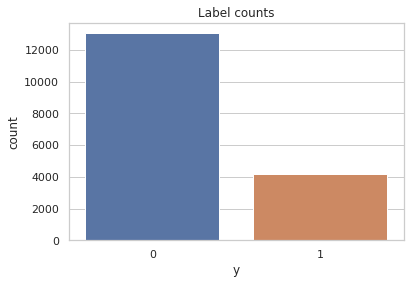

In [22]:
# plot distribution of label counts
sns.set(style="whitegrid")
ax = sns.countplot(x="y", data=df_sample)
ax.set(title="Label counts")
plt.show()

We observe that `y` target values equal to 0 are dominant, corresponding to around three-quarters of the dataset labels. 

## 3.3 EDA - Mean and median values with respect to target label categories

Here, we explore mean values of numeric variables with respect to label target categories. This is important for creating recursive partitions of regions into homogeneous zones in tree-based algorithms.

In [23]:
df_sample.groupby(df_sample.y)['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10',
                               'n11', 'n12', 'n13'].mean()

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13
y,,,,,,,,,,,,,
0,3.054829,99.360181,21.275617,7.656509,22992.466445,133.619206,12.037010,12.884176,102.645692,0.552403,2.152494,0.477289,8.985493
1,4.858596,139.142449,31.775907,6.466897,9293.685274,64.965527,24.526908,12.146092,110.876712,0.810877,3.992172,1.482321,6.056479


Explore median values of numeric variables with respect to label target categories. This may allow us to more evenly split the numeric variables.

In [24]:
df_sample.groupby(df_sample.y)['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10',
                               'n11', 'n12', 'n13'].median()

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13
y,,,,,,,,,,,,,
0,1.0,3,7.0,4.0,3057.0,41.0,2.0,8.0,38.0,0.0,1.0,0.0,5.0
1,2.0,4,5.0,4.0,1316.0,15.0,6.0,7.0,36.0,1.0,2.0,0.0,3.0


The above analysis indicates that the numeric values are ordinal in nature and can be treated as categorical for the modeling analysis.

## 3.4 EDA - Correlation Heat Map of Numeric Variables

Correlation heat map of the numeric variables allows us to visualize whether there are non-orthogonal variables and whether we can reduce the dimensionality of our data in the modeling analysis.

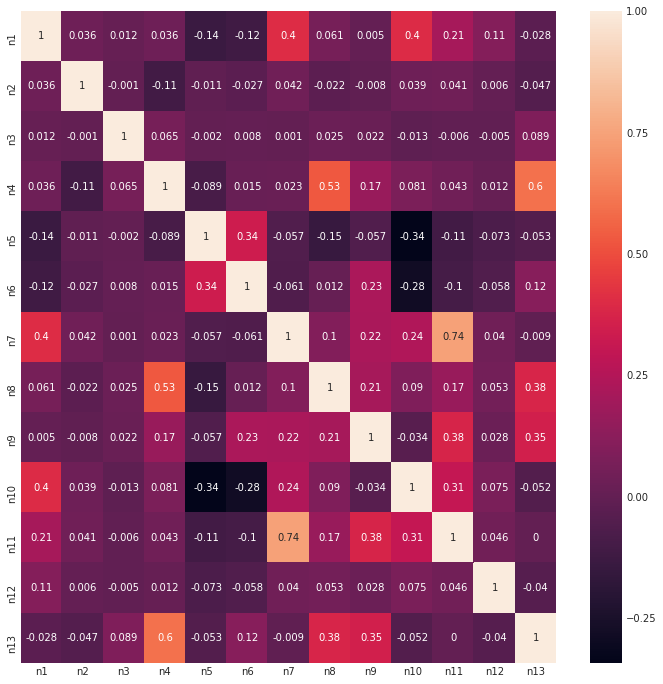

In [13]:
df_integers = df_sample.iloc[:,1:14]

var_corr = df_integers.corr()
var_corr = var_corr.round(3)
# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)

# Fix axes
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

The most positively correlated feature pairs from this sample are:
- `n7` and `n11` (_p_ = .74 in this sample);
- `n4` and `n13` (_p_ = .6 in this sample);
- `n4` and `n8` (_p_ = .53 in this sample);
- `n7` and `n1` (_p_ = .4 in this sample);
- `n10` and `n1` (_p_ = .4 in this sample);

The most negatively correlated feature pairs from this sample are:
- `n5` and `n10` (_p_ = -.34 in this sample);
- `n6` and `n10` (_p_ = -.28 in this sample)

Following this correlation analysis, since we did not consider these features to be strongly correlated, we were not concerned with effects of multicollinearity and chose to keep these features for the modeling implementation.

## 3.5 EDA - Assessment of class dominance (imbalance) across features

Next, we examine the distribution of value counts (in percentage terms) for each of the variables. 

In [25]:
# Show top value counts for each variable
for col in df_sample.columns:
    print("Top percentage value counts for variable", col)
    print((df_sample[col].value_counts(dropna=False)/len(df_sample) * 100).head())
    print("")

Top percentage value counts for variable y
0    75.659535
1    24.340465
Name: y, dtype: float64

Top percentage value counts for variable n1
NaN    44.030846
0.0    23.673682
1.0     9.874181
2.0     5.554589
3.0     3.415087
Name: n1, dtype: float64

Top percentage value counts for variable n2
 0    16.617383
 1    15.185250
-1    10.529367
 2     5.427031
 3     3.159970
Name: n2, dtype: float64

Top percentage value counts for variable n3
NaN    21.719719
1.0    12.378964
2.0     8.581203
3.0     5.989447
4.0     5.328463
Name: n3, dtype: float64

Top percentage value counts for variable n4
NaN    21.969038
1.0    13.144315
2.0     9.648055
3.0     7.589726
4.0     6.105410
Name: n4, dtype: float64

Top percentage value counts for variable n5
NaN    2.638140
1.0    2.209080
0.0    1.687250
2.0    1.577086
4.0    1.171218
Name: n5, dtype: float64

Top percentage value counts for variable n6
NaN    22.803966
0.0     4.754450
1.0     2.817881
2.0     2.267061
3.0     2.029338
Name: n6

Several variables are dominated by select few variables (where the threshold is more than 20% dominated by one value):
- n1 is dominated by `null` values (~44% of category values);
- n3 is dominated by `null` values (~22% of category values);
- n4 is dominated by `null` values (~22% of category values);
- n6 is dominated by `null` values (~23% of category values);
- n7 is dominated by 0.0 values (~22% of category values);
- n10 is dominated by `null` values (~44% of category values);
- n11 is dominated by 1.0 values (~34% of category values);
- n12 is dominated by `null` values (~77% of category values);
- n13 is dominated by `null` values (~22% of category values);
- cat14 is dominated by `05db9164` (~50% of category values);
- cat18 is dominated by `25c83c98` (~67% of category values);
- cat20 is dominated by `0b153874` (~59% of category values); 
- cat21 is dominated by `a73ee510` (~90% of category values);
- cat30 is dominated by `e5ba7672` (~47% of category values);
- cat32 is dominated by `null` values (~44% of category values);
- cat33 is dominated by `null` values (~44% of category values);
- cat35 is dominated by `null` values (~77% of category values);
- cat36 is dominated by `32c7478e` (~44% of category values);
- cat38 is dominated by `null` values (~44% of category values);
- cat39 is dominated by `null` values (~44% of category values)

We observed that there are several features that contain a high percentage of `null` values (at least 33% `null` values). Namely, the are the features `n1`, `n10`, `n12`, `cat32`, `cat33`, `cat35`, `cat38` and `cat39`. How we treated these presented a potential challenge. For the purpose of the algorithm implemented in the subsequent section, we kept the features with high percentage null values given the predictive importance these may have. 

## 3.6 EDA - Assessment of under-represented values across features

We then assess the number of distinct unique values associated with each feature in the sample dataframe. We do this in order to assess how we will perform the discretization of the categorical features and mitigate the dimensionality problem. We note that features `cat32`, `cat33`, `cat35`, `cat38` and `cat39` are particularly troublesome to produce distinct values for given the large percentage of null values.

In [13]:
# the number of distinct features associated with each feature
# use forward fill to account for missing values in some categorical variables


print("{}\t| {:10s}\t| {:10s}".format("Feature","Distinct Values","Distinct Values as a Percent of Total"))
print("="*100)
for col in df_sample.columns[0:32]:
    unique_values = len(np.unique(df_sample[col].ffill()))
    unique_values_pct = len(np.unique(df_sample[col].ffill()))/len(df_sample) * 100
    print(" {}\t| {:6d}\t\t| {:6f}".format(str(col),unique_values,unique_values_pct))

print(" {}\t| {:6d}\t\t| {:6f}".format(str('cat34'),len(np.unique(df_sample['cat34'].ffill())),len(np.unique(df_sample['cat34'].ffill()))/len(df_sample)* 100)) 
print(" {}\t| {:6d}\t\t| {:6f}".format(str('cat36'),len(np.unique(df_sample['cat36'].ffill())),len(np.unique(df_sample['cat36'].ffill()))/len(df_sample)* 100)) 
print(" {}\t| {:6d}\t\t| {:6f}".format(str('cat37'),len(np.unique(df_sample['cat37'].ffill())),len(np.unique(df_sample['cat37'].ffill()))/len(df_sample)* 100)) 
    

Feature	| Distinct Values	| Distinct Values as a Percent of Total
 y	|      2		| 0.011596
 n1	|     90		| 0.521830
 n2	|   1168		| 6.772192
 n3	|    308		| 1.785818
 n4	|     70		| 0.405868
 n5	|   8158		| 47.300980
 n6	|    942		| 5.461819
 n7	|    316		| 1.832203
 n8	|     55		| 0.318896
 n9	|    926		| 5.369050
 n10	|      7		| 0.040587
 n11	|     68		| 0.394271
 n12	|     43		| 0.249319
 n13	|     97		| 0.562417
 cat14	|    232		| 1.345161
 cat15	|    426		| 2.469995
 cat16	|   9713		| 56.317041
 cat17	|   6523		| 37.821070
 cat18	|     77		| 0.446454
 cat19	|      9		| 0.052183
 cat20	|   4213		| 24.427437
 cat21	|    121		| 0.701571
 cat22	|      3		| 0.017394
 cat23	|   4590		| 26.613324
 cat24	|   2541		| 14.732997
 cat25	|   9056		| 52.507682
 cat26	|   2060		| 11.944106
 cat27	|     24		| 0.139155
 cat28	|   2661		| 15.428770
 cat29	|   8015		| 46.471850
 cat30	|     10		| 0.057981
 cat31	|   1438		| 8.337682
 cat34	|   8616		| 49.956514
 cat36	|     13		| 0.075375
 cat37	|  

We observe that the features `n5`, `cat16`, `cat17`, `cat20`, `cat23`, `cat25`, `cat29`, `cat34` and `cat37` are comprised of distinct values that are over 20% of total values. In other words, these features contain a large number of under-represented values. This is another potential challenge to be addressed in the algorithm implementation as it would cause high dimensionality if we were to treat each value as its own feature through non-discretionary one-hot encoding. 

In order to mitigate the dimensionality issue, we impose a criteria for one-hot encoding features for a certain threshold of distinct values. Following the reference paper, de Wit (2014), we attempt an approach of applying one-hot encoding to features with less than 3,000 and another approach applying one-hot encoding to features with over 10,000 distinct values. For features with over 3K+ and 10K+ unique values, we decide to create a stash variable that comprises the least represented values for each original feature.

# Section 4. Algorithm Implementation

## 4.1 Data Transformation

### 4.1.1 Data Transformation - Variable Occurence as a Hyperparameter

The very high number of discrete numerical and string categorical variables with long tails inhibits the use of one-hot-encoding on the full set of features. Intuitively the long tails, that is, the vast majority of variables with low counts, implies a model trained on all those features may encounter higher variance tradeoff.

In order to reduce the feature space and the model variance we stashed variables with low occurence counts into a unique stash variable for each column. We tried two minimum occurence thresholds. 
A minimum count threshold of 10,000 for each unique variable produced a feature set of 9,965 variables. 
Using this threshold level as a hyperparameter in our modelling approach we proceeded to compare the model performance with a lower threshold of minimum 3,000 occurences resulting in a feature set of 25,373 variables. This implementation can be seen in section 4.2.1


### 4.1.2 Data Transformation - Hashing Function

We hash transformed the raw data with the full features and varied the number of fixed feature vectors and tried to target a log loss near the log loss performance of the two minimum occurence count one-hot-encoded models. As expected it required a fixed feature set of $2^{18}$ = 262,144 variables to achieve a comparable result. This vindicated our assumption that the majority of variables introduce a higher variance to the models.

## 4.2 Logistic Regression

### 4.2.1 Implementation - Transform Data - Categorical variable occurence threshold

In [ ]:
# To run, exxecute in bash shell
# python submit_job_to_bigger_cluster.py --project_id=${PROJECT_ID} --zone=us-east1-b --cluster_name=samt --gcs_bucket=${BUCKET_NAME} --key_file=$HOME/MIDS/w261.json --create_new_cluster --pyspark_file=data_transform_ohe.py


import time


from pyspark.sql import SQLContext
from pyspark.sql import SparkSession 


from pyspark.sql.types import *
from pyspark.sql.functions import lit, when, col, approx_count_distinct
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, OneHotEncoderEstimator, VectorAssembler, FeatureHasher

from pyspark.conf import SparkConf

app_name = "ohe"

#set session configuration
conf=SparkConf()
conf.set("spark.sql.parquet.compression.codec", "snappy")
#Create Spark session
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .getOrCreate()
        
sc = spark.sparkContext
sqlContext = SQLContext(sc)

spark
#print session configuration
for object in sc.getConf().getAll():
    print(object)

INPUT_FILE = 'gs://261_projectdata/261project_data/df.parquet'
OUT_FILE = 'gs://261_projectdata/261project_data/df_ohe_10k.parquet'
#this variable takes the minimum category occurence count as the threshold
# CASE 1 - 10_000
#CASE 2 - 3_000
THRESHOLD = 10_000

# Column names which will be transformed
my_cats = ['cat13','cat14', 'cat15', 'cat16', 'cat17',
           'cat18', 'cat19', 'cat20', 'cat21', 'cat22',
           'cat23', 'cat24', 'cat25', 'cat26', 'cat27',
           'cat28', 'cat29', 'cat30', 'cat31', 'cat32',
           'cat33', 'cat34', 'cat35', 'cat36', 'cat37',
           'cat38', 'cat39']

my_nums = ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7',
           'n8', 'n9', 'n10', 'n11', 'n12']


#load file as dataframe
df_pq = spark.read.load(INPUT_FILE)
print(f' Total number of Rows = {df_pq.count()}')


def transform_str_col(df, cat_name):
    """ Transform the string 'cat_name' column based on the THRESHOLD
        for occurence count.
    Input -     Dataframe and the column name to be transformed
    Output -    Return dataframe with transformed column 
                where low occurence variables --> 'stash_$col_name'
    """
    df_uniq_counts = df.groupBy(cat_name).count()
    
    #get values that occur above the threshold and broadcast it
    keep_vars = sc.broadcast(df_uniq_counts.filter(df_uniq_counts['count'] > THRESHOLD)\
                            .select(df_uniq_counts[cat_name])\
                            .rdd.flatMap(lambda x: x).collect())
    
    #broadcast the value to replace the low occurance values
    replace_val = sc.broadcast('stash_' + str(cat_name))


    
    #name the new column
    cat_t = str(cat_name) + '_t'
    
    df = df.withColumn(cat_t, when(col(cat_name).isin(keep_vars.value), col(cat_name)).otherwise(lit(replace_val.value)))
    df = df.drop(cat_name)
    return df



def transform_num_col(df, cat_name):
    """ Transform the numerical 'cat_name' column based on the THRESHOLD
        for occurence count.
    Input -   Dataframe and the column name to be transformed
    Output -  Return dataframe with transformed column where 
                low occurence variables --> 1_000_0xx' based on my_nums dict
    """
  #list of stash variables named so its easy to identify in coefficient analysis
    my_nums = {'n1':1_000_001, 'n2':1_000_002,
               'n3':1_000_003, 'n4':1_000_004,
               'n5':1_000_005, 'n6':1_000_006,
               'n7':1_000_007, 'n8':1_000_008, 
               'n9':1_000_009, 'n10':1_000_010,
               'n11':1_000_011, 'n12':1_000_012}
    
    df_uniq_counts = df.groupBy(cat_name).count()
    
    #get values that occur above the threshold and broadcast it
    keep_vars = sc.broadcast(df_uniq_counts.filter(df_uniq_counts['count'] > THRESHOLD)\
                            .select(df_uniq_counts[cat_name])\
                            .rdd.flatMap(lambda x: x).collect())
    
    #broadcast the stash variable placeholder value to replace the low occurance values
    replace_val = sc.broadcast(my_nums[cat_name])


    
    #name the new column
    cat_t = str(cat_name) + '_t'
    #if value is in the broadcasted high occurence list, then keep the value, other replace it with the placeholder
    df = df.withColumn(cat_t, when(col(cat_name).isin(keep_vars.value), col(cat_name)).otherwise(lit(replace_val.value)))
    df = df.drop(cat_name)
    return df

#Apply transform on numerical columns
tot_time = 0
for c in my_nums:

    start = time.time()
    print(f'Transforming Numerical column.. {c}')
    df_pq = transform_num_col(df_pq, c)
    time_taken = time.time() - start
    print(f"... completed job in {time_taken} seconds")
    tot_time += time_taken
print(f'total time taken = {tot_time}')

print('\n')
print('----'* 20)
print('\n')

#Apply transform on  string columns
tot_time = 0
for c in my_cats:

    start = time.time()
    print(f'Transforming Categorical column.. {c}')
    df_pq = transform_str_col(df_pq, c)
    time_taken = time.time() - start
    print(f"... completed job in {time_taken} seconds")
    tot_time += time_taken
print(f'total time taken = {tot_time}')

df_pq.cache()




#specify columns to turn from string categorical variables to numerical categorical representation
cat_cols = ['n1_t', 'n2_t', 'n3_t', 'n4_t', 'n5_t', 'n6_t', 'n7_t',
           'n8_t', 'n9_t', 'n10_t', 'n11_t', 'n12_t',
           'cat13_t','cat14_t', 'cat15_t', 'cat16_t', 'cat17_t',
           'cat18_t', 'cat19_t', 'cat20_t', 'cat21_t', 'cat22_t',
           'cat23_t', 'cat24_t', 'cat25_t', 'cat26_t', 'cat27_t',
           'cat28_t', 'cat29_t', 'cat30_t', 'cat31_t', 'cat32_t',
           'cat33_t', 'cat34_t', 'cat35_t', 'cat36_t', 'cat37_t',
           'cat38_t', 'cat39_t']

cat_str_indx = ['n1_t_Indx', 'n2_t_Indx', 'n3_t_Indx', 'n4_t_Indx', 'n5_t_Indx', 'n6_t_Indx', 'n7_t_Indx',
               'n8_t_Indx', 'n9_t_Indx', 'n10_t_Indx', 'n11_t_Indx', 'n12_t_Indx',
               'cat13_t_Indx','cat14_t_Indx', 'cat15_t_Indx', 'cat16_t_Indx', 'cat17_t_Indx',
               'cat18_t_Indx', 'cat19_t_Indx', 'cat20_t_Indx', 'cat21_t_Indx', 'cat22_t_Indx',
               'cat23_t_Indx', 'cat24_t_Indx', 'cat25_t_Indx', 'cat26_t_Indx', 'cat27_t_Indx',
               'cat28_t_Indx', 'cat29_t_Indx', 'cat30_t_Indx', 'cat31_t_Indx', 'cat32_t_Indx',
               'cat33_t_Indx', 'cat34_t_Indx', 'cat35_t_Indx', 'cat36_t_Indx', 'cat37_t_Indx',
               'cat38_t_Indx', 'cat39_t_Indx']

cat_vecs = ['n1v', 'n2v', 'n3v', 'n4v', 'n5v', 'n6v', 'n7v',
           'n8v', 'n9v', 'n10v', 'n11v', 'n12v',
           'cat13v','cat14v', 'cat15v', 'cat16v', 'cat17v',
           'cat18v', 'cat19v', 'cat20v', 'cat21v', 'cat22v',
           'cat23v', 'cat24v', 'cat25v', 'cat26v', 'cat27v',
           'cat28v', 'cat29v', 'cat30v', 'cat31v', 'cat32v',
           'cat33v', 'cat34v', 'cat35v', 'cat36v', 'cat37v',
           'cat38v', 'cat39v']

#convert categorical variables to numerical categories
indexers = [StringIndexer(inputCol= c, 
                         outputCol="{0}_Indx".format(c), 
                         handleInvalid="keep") 
           for c in cat_cols]
#Create a list representation of the numerical categorical representation
encoder = OneHotEncoderEstimator(inputCols = [indexer.getOutputCol() for indexer in indexers], 
                                  outputCols = cat_vecs, 
                                  dropLast = True)
#adding a assembler step which creates a sparse representation of an indexed column
assembler = VectorAssembler(inputCols=encoder.getOutputCols(), 
                           outputCol = 'features')
#creating the full transform pipeline  
start = time.time()
print(f'Running pipeline to create sparse vectors.. ')                            
pipeline = Pipeline(stages = indexers + [encoder] + [assembler] )

model = pipeline.fit(df_pq)

transformed = model.transform(df_pq)

drop_cols = cat_str_indx + cat_vecs
final_df = transformed.drop(*drop_cols).cache()

time_taken = time.time() - start
print(f"... completed job in {time_taken} seconds")


print('writing file to parquet')
final_df.write.parquet(OUT_FILE, compression='snappy', mode='overwrite')
print('Done.')


### 4.2.2 Implementation - Logistic Regression - Model Training and Evaluation

In [ ]:
# python submit_job_to_bigger_cluster.py --project_id=${PROJECT_ID} --zone=us-east1-b --cluster_name=samt --gcs_bucket=${BUCKET_NAME} --key_file=$HOME/MIDS/w261.json --create_new_cluster --pyspark_file=lr_model.py

import time
import math


from pyspark.sql import SQLContext
from pyspark.sql import SparkSession 


from pyspark.sql.types import *
from pyspark.sql.functions import lit, when, col, approx_count_distinct, mean, log, udf

from pyspark.ml.classification import LogisticRegression

from pyspark.conf import SparkConf


app_name = "logistic_regression"

#set spark session options
conf=SparkConf()
conf.set("spark.sql.parquet.compression.codec", "snappy")
#initiate the spark session
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

spark
#print all the session options and settings
for object in sc.getConf().getAll():
    print(object)

#set the global variables
MAX_ITER = 10       #number of model training epochs
THRESHOLD = 0.45    #model training threshold for classification probability
EPSILON = 1e-16     #variable to force bounded solution for log trransforms

#import one hot encoded file
INPUT_FILE = 'gs://261_projectdata/261project_data/df_ohe_10k.parquet'
OUTPUT_FILE = 'gs://261_projectdata/results/ohe_10k_result.csv'

df_pq = spark.read.parquet(INPUT_FILE)\
                .select('y', 'features')

print(f' Total number of Rows = {df_pq.count()}')
#remove records where the label is missing
df_pq = df_pq.na.drop(subset = ["y"])

print(f' Dropped NULL values from prediction variable. Total number of Rows = {df_pq.count()}')
#create train-test split
train_y_all, test_y_all = df_pq.randomSplit([0.8, 0.2])
df_pq.unpersist()

#change the name of the dependent variable column
test = test_y_all.selectExpr("y as labels", "features")
print(f' Total number of Rows in the TEST set = {test.count()}')
test.show(n=5)
#force a binary classification 0 or 1 on the training data and save as column 'labels'
train_y = train_y_all.withColumn('labels', when(col('y') > 0.0, lit(1)).otherwise(lit(0)))
train_y_all.unpersist()
#remove the old dependent variable
train = train_y.drop('y')
train_y.unpersist()

print(f' Total number of Rows in the TRAIN set = {train.count()}')

train.show(n=10)


#Get the percentage of values in the positive class, to set the baseline log loss
mean_prob = train.select(mean(col('labels'))).collect()[0]['avg(labels)']
print(f'Positive class in the training data = {mean_prob * 100} %')

#assign mean probability as the baseline probability estimate
train_prob = train.withColumn('base_prob', lit(mean_prob))
train.unpersist()

# calculate baseilne logloss  
train_ll = train_prob.withColumn('logloss', when(col('labels') > 0.0, - log(col('base_prob') + EPSILON))\
                                       .otherwise( - log(1.0 - col('base_prob') + EPSILON)))
train_prob.unpersist()
#get the mean of the logloss
mean_ll = train_ll.select(mean(col('logloss'))).collect()[0]['avg(logloss)']
print(f'Baseline Log loss for the training data = {mean_ll}')



#specify the model and hyperparameters
lr = LogisticRegression(featuresCol = 'features',
                        labelCol='labels', 
                        maxIter = MAX_ITER, 
                        standardization = False,
                        elasticNetParam = 0.0, 
                        threshold = THRESHOLD
                        )

start = time.time()
print('Training model...')
lr_model = lr.fit(train_ll)
time_taken = time.time() - start
print(f'Training completed ...in {time_taken}')




def sigmoid(rawPrediction):
    #apply affine transformation
    return 1 / (1 + math.exp(- rawPrediction))

def extract_from_vector(vec, i):
    """ Input: VectorUDT data type
        Output: float type at index (i)
    """
    try:
        return float(vec[i])
    except ValueError:
        return None

#register UDFs    
get_probability = udf(sigmoid, DoubleType())
get_val = udf(extract_from_vector, DoubleType())

#Get predictions on test data
result = lr_model.transform(test)

#Apply affine transformation to the linear regression output
result2 = result.withColumn('calc_prob', get_probability(get_val("rawPrediction", lit(1))))
# calculate log loss
result3 = result2.withColumn('logloss', when(col('labels') > 0.0, - log(col('calc_prob') + EPSILON))\
                                       .otherwise( - log(1.0 - col('calc_prob') + EPSILON)))


test_mean_ll = result3.select(mean(col('logloss'))).collect()[0]['avg(logloss)']
print(f'Baseline Log loss for the training data = {mean_ll}')
print(f'MODEL Log loss for the training data = {test_mean_ll}')

result3.select(['features', 'labels' ,'prediction', 'calc_prob', 'probability', 'logloss']).show(n=10, truncate=True)

analyze = result3.select('labels', 'prediction')
analyze = analyze.withColumn("prediction", analyze["prediction"].cast(IntegerType()))
analyze = analyze.withColumn("labels", analyze["labels"].cast(IntegerType()))
result3.unpersist()
#Create SQL queries table
sqlContext.registerDataFrameAsTable(analyze, "results")
#Get metrics for precision recall calculations
TP = spark.sql("""SELECT COUNT(prediction)
                    FROM results
                    WHERE labels = 1 AND prediction = 1
                    """).collect()[0][0]

TN = spark.sql("""SELECT COUNT(prediction)
                    FROM results
                    WHERE labels = 0 AND prediction = 0
                    """).collect()[0][0]

FP = spark.sql("""SELECT COUNT(prediction)
                    FROM results
                    WHERE labels = 0 AND prediction = 1
                    """).collect()[0][0]

FN = spark.sql("""SELECT COUNT(prediction)
                    FROM results
                    WHERE labels = 1 AND prediction = 0
                    """).collect()[0][0]


print(f'Precision = {TP/(TP + FP) * 100} %')

print(f'Recall = {TP/(TP + FN) * 100} %')

features = [x["name"] for x in sorted(train_ll.schema["features"].metadata["ml_attr"]["attrs"]["binary"], 
                                      key=lambda x: x["idx"]
                                     )]

#Extract feature names and indices from table metadata
schema = StructType([StructField("feature", StringType()),
                    StructField("coeff", FloatType())
                    ])

# Create dataframe of coefficients
result_df = spark.createDataFrame(zip(features, lr_model.coefficients.tolist()), schema=schema)
result_df.show(n=5)

#save to CSV file
result_df.coalesce(1).write.csv(OUTPUT_FILE, mode='overwrite')

### 4.2.3 Implementation - Logistic Regression - Hashing Function - Training and Evaluation

In [ ]:



import time
import math

from pyspark.sql import SQLContext
from pyspark.sql import SparkSession 

from pyspark.conf import SparkConf

from pyspark.sql.types import *
from pyspark.sql.functions import lit, when, col, approx_count_distinct, mean, log, udf
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import FeatureHasher



app_name = "logistic_regression"

conf=SparkConf()

spark = SparkSession\
        .builder\
        .appName(app_name)\
        .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

spark

for object in sc.getConf().getAll():
    print(object)
#set the global variables
NUM_FEATURES = 2**18  #parameter for setting the number of mapped feature space
MAX_ITER = 10       #number of model training epochs
THRESHOLD = 0.45    #model training threshold for classification probability
EPSILON = 1e-16     #variable to force bounded solution for log trransforms


INPUT_FILE = 'gs://261_projectdata/261project_data/df.parquet'



my_cols = ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7',
           'n8', 'n9', 'n10', 'n11', 'n12',
           'cat13','cat14', 'cat15', 'cat16', 'cat17',
           'cat18', 'cat19', 'cat20', 'cat21', 'cat22',
           'cat23', 'cat24', 'cat25', 'cat26', 'cat27',
           'cat28', 'cat29', 'cat30', 'cat31', 'cat32',
           'cat33', 'cat34', 'cat35', 'cat36', 'cat37',
           'cat38', 'cat39']



df_pq = spark.read.parquet(INPUT_FILE)


print(f'Creating Hashed feature with {NUM_FEATURES} number of vectors ...')
start = time.time()

hasher = FeatureHasher(inputCols=my_cols, outputCol="features", numFeatures = NUM_FEATURES)

hash_transformed = hasher.transform(df_pq).select('y', 'features')
print(f'Hashed feature vector completed ...in {time.time() - start}')

df_pq.unpersist()

hash_transformed.show(n=5, truncate=True)
#create train-test split
print('Creating train-test split..')
train_y_all, test_y_all = hash_transformed.randomSplit([0.8, 0.2], seed=10)
hash_transformed.unpersist()
#change the name of the dependent variable column
print('Creating test set..')
test = test_y_all.selectExpr("y as labels", "features")
test.show(n=5)
#force a binary classification 0 or 1 on the training data and save as column 'labels'
print('Creating train set..')
train_y = train_y_all.withColumn('labels', when(col('y') > 0.0, lit(1)).otherwise(lit(0)))
train_y_all.unpersist()

train = train_y.drop('y')
train_y.unpersist()

train.show(n=10)


#Get the percentage of values in the positive class, to set the baseline log loss
mean_prob = train.select(mean(col('labels'))).collect()[0]['avg(labels)']
print(f'Positive class in the training data = {mean_prob * 100} %')

#assign mean probability as the baseline probability estimate
train_prob = train.withColumn('base_prob', lit(mean_prob))
train.unpersist()

# calculate baseilne logloss  
train_ll = train_prob.withColumn('logloss', when(col('labels') == 1.0, - log(col('base_prob') + EPSILON))\
                                       .otherwise( - log(1.0 - col('base_prob') + EPSILON)))
train_prob.unpersist()

mean_ll = train_ll.select(mean(col('logloss'))).collect()[0]['avg(logloss)']
print(f'Baseline Log loss for the training data = {mean_ll}')
#specify the model and hyperparameters
lr = LogisticRegression(featuresCol = 'features',
                        labelCol='labels', 
                        maxIter = MAX_ITER, 
                        standardization = False,
                        elasticNetParam = 0.0, 
                        threshold = THRESHOLD
                        )

start = time.time()
print('Training model...')
lr_model = lr.fit(train_ll)
time_taken = time.time() - start
print(f'Training completed ...in {time_taken}')

def sigmoid(rawPrediction):
    #apply affine transformation
    return 1 / (1 + math.exp(- rawPrediction))

def extract_from_vector(vec, i):
    """ Input: VectorUDT data type
        Output: float type at index (i)
    """
    try:
        return float(vec[i])
    except ValueError:
        return None

#register UDFs      
get_probability = udf(sigmoid, DoubleType())
get_val = udf(extract_from_vector, DoubleType())

#Get predictions on test data
result = lr_model.transform(test)

#Apply affine transformation to the linear regression output
result2 = result.withColumn('calc_prob', get_probability(get_val("rawPrediction", lit(1))))
# calculate log loss
result3 = result2.withColumn('logloss', when(col('labels') > 0.0, - log(col('calc_prob') + EPSILON))\
                                       .otherwise( - log(1.0 - col('calc_prob') + EPSILON)))


test_mean_ll = result3.select(mean(col('logloss'))).collect()[0]['avg(logloss)']
print(f'Baseline Log loss for the training data = {mean_ll}')
print(f'MODEL Log loss for the training data = {test_mean_ll}')

analyze = result3.select('labels', 'prediction')
analyze = analyze.withColumn("prediction", analyze["prediction"].cast(IntegerType()))
analyze = analyze.withColumn("labels", analyze["labels"].cast(IntegerType()))

#Create SQL queries table
sqlContext.registerDataFrameAsTable(analyze, "results")
#Get metrics for precision recall calculations
TP = spark.sql("""SELECT COUNT(prediction)
                    FROM results
                    WHERE labels = 1 AND prediction = 1
                    """).collect()[0][0]

TN = spark.sql("""SELECT COUNT(prediction)
                    FROM results
                    WHERE labels = 0 AND prediction = 0
                    """).collect()[0][0]

FP = spark.sql("""SELECT COUNT(prediction)
                    FROM results
                    WHERE labels = 0 AND prediction = 1
                    """).collect()[0][0]

FN = spark.sql("""SELECT COUNT(prediction)
                    FROM results
                    WHERE labels = 1 AND prediction = 0
                    """).collect()[0][0]

P = spark.sql("""SELECT COUNT(labels)
                    FROM results
                    WHERE labels = 1
                    """).collect()[0][0]

N = spark.sql("""SELECT COUNT(labels)
                    FROM results
                    WHERE labels = 0
                    """).collect()[0][0]

print(f'Precision = {TP/(TP + FP) * 100} %')

print(f'Recall = {TP/(TP + FN) * 100} %')

### 4.2.4 Logistic Regression - Result Evaluation

Below we have plotted the log loss of the training data for the logistic regression models 3K-threshold (with 25,373 variables), the 10K-threshold (with 9,965 variables) and the hash model (262,144 variables, without any data transforms).

The 3K and the 10K threshold models test runs match the training loss estimates with 10 iterations. This implies that the models are generalizing well, but the 3K model is able to capture a higher level of variance and thus improve of the comparative accuracy, than the 10K model which is underfitting the data and producing a higher logloss.

The hash model, which is hashing the entire data to 262,144 variables is overfitting the data, and its test loss is higher than the model with only 25,000 variables. Thus proving our intuitive assumption that the feature space need to be reduced to reduce the model variance.

In [51]:
model_loss_3K = [0.499029, 0.491585, 0.487683, 0.474038, 0.471372, 0.467517, 0.467218, 0.465899, 0.465557, 0.465180]
model_loss_10K = [0.502777, 0.496957, 0.493552, 0.480277, 0.477862, 0.474202, 0.473822, 0.472661, 0.472306, 0.471934]
model_loss_hash = [0.505454, 0.498507, 0.485948, 0.480282, 0.476191, 0.470736, 0.466912, 0.465075, 0.464344, 0.463487]
test_loss = [0.46562832410932214 , 0.47215762480930773, 0.4697991907246451]
x_val = [0,1,2]
x_ticks = ['LR-3K', 'LR-10K', 'Hash']

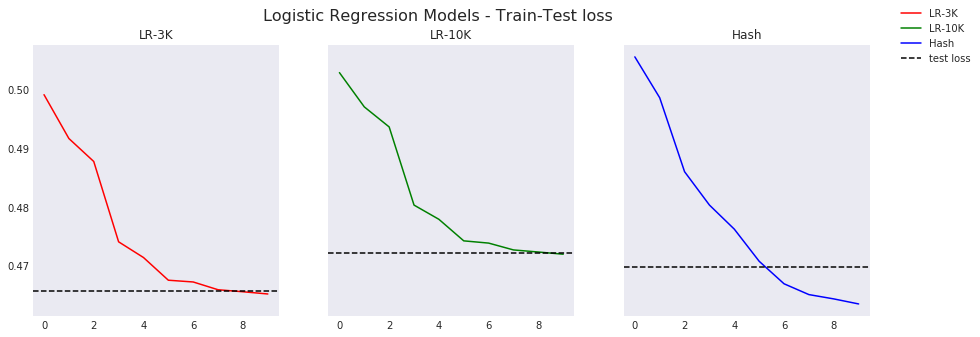

In [53]:
series = [model_loss_3K, model_loss_10K, model_loss_hash]
color = ['r', 'g', 'b']
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))
for indx, ax in enumerate(axes):
    ax.plot(series[indx], color=color[indx], label=x_ticks[indx])
    l1 = ax.axhline(test_loss[indx],color='black',ls='--')
    ax.set_title(x_ticks[indx])

l1.set_label('test loss')
fig.suptitle('Logistic Regression Models - Train-Test loss', fontsize=16)
fig.legend()
plt.show()

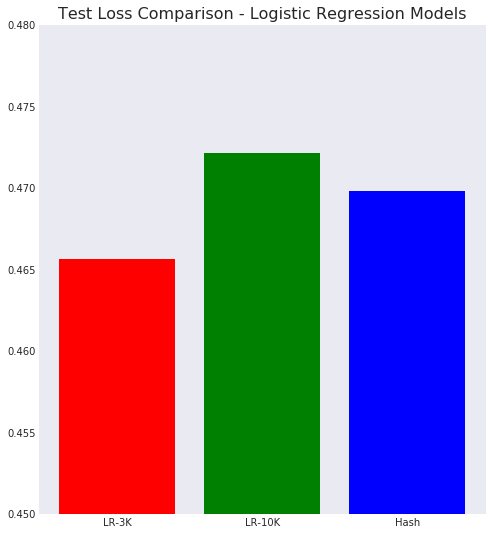

In [62]:
plt.figure(figsize=(8,9))
plt.bar(x_val, test_loss, align='center', color=color)
plt.ylim(0.45, 0.48)
plt.xticks(x_val, x_ticks)
plt.title('Test Loss Comparison - Logistic Regression Models', fontsize=16)
plt.show()



### 4.2.5  Logistic regression -  Feature Coefficients Analysis

In our project, we utilized one-hot encoding to binarize both our numerical and categorical features. We realized that because each feature may contain thousands of unique values, a conventional (or naive) one-hot encoding method would result in the curse of dimensionality, where we would end up having more features than data (i.e. more columns than we would rows). For this reason, we chose to impose a threshold of distinct values and use the idea of a "stash" feature, where for each feature, we would one-hot encode a unique value if it appeared more times than our threshold, otherwise we would assign it our stash value, which would also be one-hot encoded. This way, we created a new category per-feature which represented the under-represented unique values of certain features and mitigate the dimensionality issue. We show in this section that these variables would in fact not have a significant impact on our model, thus validating this method.


Below, we will show how we analized our coefficients and validated our one-hot encoding implementation (Following article as a guide: https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa):

In [5]:
column_names = ['features','weights']
coef_10k = pd.read_csv('./logistic_regression/results/Coeff_10K_threshold.csv',sep=",", names=column_names)
coef_3k = pd.read_csv('./logistic_regression/results/Coeff_3K_threshold.csv',sep=",", names=column_names)


The coefficients, $\beta_{i}$ resulting from logistic regression are log-odds. To be converted to odds, we take the exponent of the coefficients. Following this transform we can say that the presence of the feature multiplies the odds of a click given an advertisement display by $e^{\beta_{i}}$.

In [6]:
coef_10k['odds'] = np.exp(coef_10k['weights'])
coef_3k['odds'] = np.exp(coef_3k['weights'])

Assign a ranking for features sorted by coefficient weights in descending order.

In [7]:
coef_10k['rank'] = coef_10k['weights'].rank(ascending=False)
coef_3k['rank'] = coef_3k['weights'].rank(ascending=False)

Below, we sort the features by their coefficients and odds to visualize which stashed features had significant impact on our model

In [8]:
# inspect the 10 largest positive weights for the Coeff_10K_threshold dataset
coef_10k.sort_values(by='weights',ascending=False).head(10)

,features,weights,odds,rank
9574,cat37v_e5c2573e,4.187770,65.875724,1.0
6845,cat26v_61537f27,3.051090,21.138362,2.0
5980,cat25v_977d7916,2.667691,14.406663,3.0
9737,cat39v_e7ecb821,1.727998,5.629373,4.0
8580,cat31v_fe74f288,1.711703,5.538383,5.0
7091,cat28v_2d49999f,1.516405,4.555818,6.0
6881,cat27v_ab7390e9,1.484701,4.413647,7.0
9561,cat37v_e944e245,1.210541,3.355299,8.0
7348,cat28v_bd7b7794,1.150319,3.159199,9.0
4258,cat23v_f1b45aab,1.120861,3.067496,10.0


In [9]:
# inspect the 10 largest negative weights for the the Coeff_10K_threshold dataset
coef_10k.sort_values(by='weights',ascending=True).head(10)

,features,weights,odds,rank
9833,cat39v_56009c93,-1.400403,0.246498,9965.0
7284,cat28v_1620a246,-1.393744,0.248144,9964.0
6879,cat27v_26ac7cf4,-1.343043,0.261050,9963.0
2631,cat16v_e159e1de,-1.136020,0.321094,9962.0
5958,cat25v_8a48eb95,-1.115564,0.327730,9961.0
3225,cat20v_12343fcc,-1.102595,0.332009,9960.0
7547,cat28v_14d05219,-1.085577,0.337707,9959.0
3115,cat17v_2788fed8,-1.001742,0.367239,9958.0
8346,cat31v_b49c9b63,-0.992106,0.370795,9957.0
7523,cat28v_6c34b86f,-0.956747,0.384141,9956.0


In [10]:
# inspect the 10 largest positive weights for the Coeff_3K_threshold dataset
coef_3k.sort_values(by='weights',ascending=False).head(10)

,features,weights,odds,rank
23553,cat37v_e5c2573e,4.147792,63.294112,1.0
24205,cat37v_06f6f124,2.423117,11.280972,2.0
24192,cat37v_7e60320b,2.041644,7.703265,3.0
11007,cat22v_stash_cat22,1.917090,6.801141,4.0
10106,cat20v_af8f31b5,1.851544,6.369647,5.0
15324,cat25v_977d7916,1.732871,5.656873,6.0
21618,cat31v_31941843,1.593091,4.918930,7.0
21135,cat31v_fe74f288,1.538607,4.658096,8.0
6262,cat16v_6dd570f4,1.528990,4.613516,9.0
18010,cat28v_2d49999f,1.504410,4.501497,10.0


In [11]:
# inspect the 10 largest negative weights for the the Coeff_3K_threshold dataset
coef_3k.sort_values(by='weights',ascending=True).head(10)

,features,weights,odds,rank
24175,cat37v_0c55705d,-1.656837,0.190741,25373.0
19243,cat28v_e8595dcb,-1.587786,0.204378,25372.0
25119,cat39v_f969c815,-1.524077,0.217822,25371.0
23977,cat37v_9579adc9,-1.482050,0.227172,25370.0
18203,cat28v_1620a246,-1.447041,0.235265,25369.0
24623,cat39v_56009c93,-1.382719,0.250895,25368.0
18713,cat28v_d8c099d7,-1.339515,0.261973,25367.0
7814,cat17v_d51317a5,-1.305992,0.270904,25366.0
23822,cat37v_2949c226,-1.300072,0.272512,25365.0
25309,cat39v_41d8ab16,-1.295096,0.273872,25364.0


#### 4.2.5.1 Visualizing Stashed Coefficient

We now have the weights of the stashed features. Below, we will plot the weights for all of our features and visualize how much of an impact the stashed features will have on our model by scattering their weights along our curve. Ideally, we would like to have these points representing the stashed feature coefficients huddled around 0, to reassure us that they have minimal impact on the model.

In [13]:
# Plots line graph of coefficients, dots for stash weights
def coeflinegraph(df, title, stashes):
    beta = np.sort(df.weights)
    plt.plot(beta)
    plt.scatter([stashes.index], [stashes.values])

    plt.title('Beta Coefficients using {} distinct counts as threshold filter'.format(title))
    plt.ylabel('Beta Coefficients')
    plt.show()

    
# Plots line graph of log-odds, dots for stash odds    
def oddslinegraph(df, title, stashes):
    odds = np.sort(df.odds)
    plt.plot(odds)
    plt.scatter([stashes.index], [stashes.values])

    
    plt.title('Odds using {} distinct counts as threshold filter'.format(title))
    plt.ylabel('Odds')
    plt.show()


In [14]:
# Access coefficeint weights and log odds for stashed features
def get_stash(df):
    df_stash_cat = df[df['features'].str.contains("stash")]
    df_stash_num = df[df['features'].str.contains("v_10000")]

    df_stash = pd.concat([df_stash_cat, df_stash_num])
    
    return df_stash['odds'], df_stash['weights']
        
# Get odds and weights for both 10k and 3k results
coef_10k_odds, coef_10k_weights = get_stash(coef_10k)

coef_3k_odds, coef_3k_weights = get_stash(coef_3k)

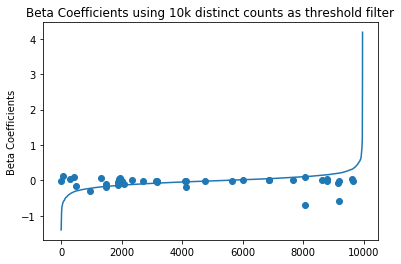

In [15]:
coeflinegraph(df=coef_10k, title='10k', stashes=coef_10k_weights)

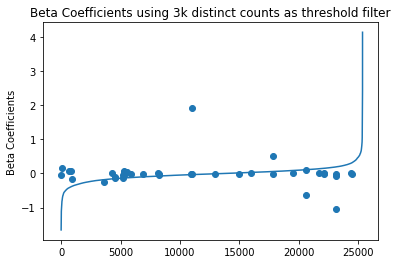

In [16]:
coeflinegraph(df=coef_3k, title='3k', stashes=coef_3k_weights)



We observe that just a small fraction of the features have a non-negligible coefficient weight. We also plot the weights of the stashed variables for each feature. As we can see, almost all of the stashed variables are clustered around 0. This is ideal, as we want the underrepresented variables to have a negligible effect within our model. In the 3,000 threshold model, we see that there are a few outliers, as some of our stashed features have significant weights. We can surmise that the model using the 10,000 threshold lessens the weight of the stashed features, as we see that nearly all of the coefficients are around 0.

Below, we plot the odds for both models. Given that these are the exponentials of the log-odds, only those odds with non-negligible weights will appear salient. Almost all values are again around 0. However, we do again see an outlier in the 3,000 threshold model.

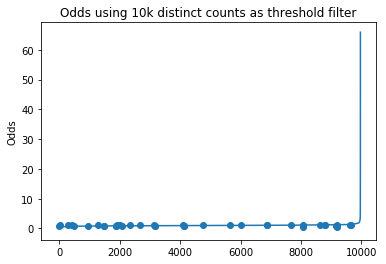

In [17]:
oddslinegraph(df=coef_10k, title='10k', stashes=coef_10k_odds)

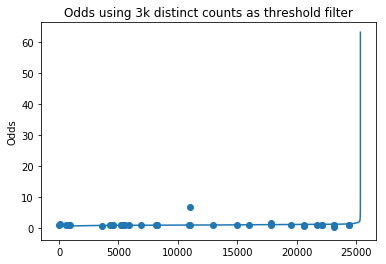

In [18]:
oddslinegraph(df=coef_3k, title='3k', stashes=coef_3k_odds)

We observe that just a small fraction of the features have a non-negligible odds interpretation.

In the 3k threshold model, just 0.1% of features have weights greater than 1. In the 10k threshold model, just 0.2% of features have weights greater than 1. We find that just one stash variable, corresponding with feature cat22 (ranked fourth) has a weight greater than 1 in the 3k threshold model. Moreover, we observe that none of the numerical features have a negligible weight.

In [19]:
# Inspect which stash variable has a non-negligible weights in the 3k threshold model."
coef_3k[coef_3k['weights']>1].sort_values(by='weights',ascending=False)


,features,weights,odds,rank
23553,cat37v_e5c2573e,4.147792,63.294112,1.0
24205,cat37v_06f6f124,2.423117,11.280972,2.0
24192,cat37v_7e60320b,2.041644,7.703265,3.0
11007,cat22v_stash_cat22,1.917090,6.801141,4.0
10106,cat20v_af8f31b5,1.851544,6.369647,5.0
15324,cat25v_977d7916,1.732871,5.656873,6.0
21618,cat31v_31941843,1.593091,4.918930,7.0
21135,cat31v_fe74f288,1.538607,4.658096,8.0
6262,cat16v_6dd570f4,1.528990,4.613516,9.0
18010,cat28v_2d49999f,1.504410,4.501497,10.0



## 4.3 Random Forest

PySpark provides a `RandomForestClassifier` algorithm in the `pyspark.ml.classification` package and we chose to use this rather than write one from scratch. In order to use this classifier, we must perform some preprocessing on the input data to get it into the format the algorithm expects.

### 4.3.1 Preprocesing - Random Forest

1. One hot encode categorical features but only emit features for categorical values who have more than 10,000 instances
2. Combine these one hot encoded features with the numerical values and vectorize them to a single dataframe column
3. Convert the target variable from a boolean value to a string value

For the first step, we chose to filter out categorical values who have less than 10,000 instances as there were several columns that had over 1 million distinct values (in the full dataset), many of which only had a handful of instances. If we were to include these in the final dataset, it would increase the dimensionality of our data by many magnitudes while leading to a high variance and failing to generalize.

Many of the included algorithms in the `pyspark.ml` package require the data to be in a vectorized format, so this step was required. Given a list of columns, the `pyspark.ml.feature.VectorAssembler` class generates a single vector column of the concatenated features with the elements ordered by the input columns. For example given this dataframe:

|`x1`|`x2`|`x3`|
|---|---|---|
|`5`|`3`|`-10`|

The `VectorAssembler` would output this value to a new column: `[5,3,-10]`.

Lastly, the target variable was changed from a boolean type to a string type which is required by the `pyspark.ml.feature.StringIndexer` class. The `StringIndexer` indexes each class and is required by the classification algorithms in PySpark.

Since random forests do not require feature engineering and are able to handle `NA` values, no other preprocessing was done. This data was saved to parquet for later use when we run the training of our algorithm. This code can be found in `random_forest/transform.py` and was executed as a PySpark job.

### 4.3.2 Training - Random Forest 
 
The data used for training was read in from the parquet files generated during the preprocessing step above but was first split into a train and test dataset with a 70/30 split. The training dataset was used for training and the test dataset was used for testing the performance of the trained model. This code for this section is located in `random_forest/train.py` and was also executed as a PySpark job.

On our first several trainings, we noticed the loss was fairly high and we discovered the class imbalance in our dataset was the likely culprit since random forests are sensitive to class imbalances in the training data. Given an imbalance, they will bias towards the class(es) that have more examples. To address this, we performed an oversampling of the underrepresented class in the training dataset. In this case the "not clicked" class ($y = 0$) comprised around 75% of the dataset, while the "clicked" class ($y = 1$) comprised the remaining 25%. Our oversampling strategy then became to duplicate the "clicked" examples twice giving a more balanced dataset. This approach lowered our loss over 35% on the test dataset. Note that this oversampling was only performed on the training dataset and not the test dataset.

Random forests have relatively few hyperparameters compared to other classification algorithms. The two important ones are the number of trees (`numTrees` parameter) and the maximum tree depth (`maxDepth` parameter). Several combinations of these were tried and we found that 40 trees gave the least amount of loss. Changing the maximum tree depth didn't have much of an effect on the loss but did cause the training process to run much longer when increased, so the default of 5 was chosen. One other hyperparameter that was tuned was the one that controls the number of bins used for continuous values (`maxBins` parameter). This also had no notable effect and was left at the default of 32.

### 4.3.3 Evaluation - Random Forest

To evaluate the performance of our model, we chose to use the log loss as discussed in Section 2. To implement this, after training, we ran prediction across the test dataset that we split earlier and calculated the loss for each test example. This value was averaged over all of the results and produced a final loss of `0.7091`.


### 4.3.4 Execution - Random Forest

To run the code:

```bash
# create an autoscaling policy for the cluster to automatically scale number of workers - only need to run first time
gcloud dataproc autoscaling-policies import autoscaling-policy --source=autoscaling.yml

# preprocess the data
python submit_job_to_cluster.py --project_id=${PROJECT_ID} --zone=${ZONE} --cluster_name=${CLUSTER_NAME} --gcs_bucket=${BUCKET} --key_file=${KEY} --create_new_cluster --pyspark_file=transform.py

# run training
python dataproc/submit_job_to_cluster.py  --project_id=${PROJECT_ID} --zone=${ZONE} --cluster_name=${CLUSTER_NAME} --gcs_bucket=${BUCKET} --key_file=${KEY} --create_new_cluster --pyspark_file=train.py
```

The preprocessing job takes around 20-30 minutes and the training job takes around 75 minutes.

## 4.4 Results

We find that the random forest algorithm has some advantages and disadvantages. Perhaps the largest advantage is that random forests do not require any feature selection and only very minor feature engineering, if any. We were able to get a random tree classifier working relatively easily using the data with a few modifications to pare down the dimensionality. Random forests are also able to compensate for the overfitting that can come from a single decision tree. However, a downside to random forests that we experienced is that they require balanced classes in the training data. Due to the high class imbalance in our dataset, we saw this manifest as a bias towards the majority class.

Logistic regression performed better in terms of the final log loss. Our model gave a better log loss when trained on the 3K (25,373 variables) vs 10K (9,965 variables) threshold data, which with a larger number of variables was able improve the prediction accuracy versus the lower variable model. This more strict 10K threshold may have lumped too may have marked variables as stash too liberally, thereby supressing the importance of some coefficients which in turn seem to have lead to better results. Furthermore, the Logistic Regression's final metrics stand at 40% and 60% for precision and recall, respectively. These prove to be better than the "guessing" method we described in Section 1 and we conclude that we have established a model that meets our requirements.

Because we chose to use one-hot-encoding, our Logistic Regression model was able to assign single coefficients to each of the unique values of the different variables we had spawned from each feature. On the other hand, Random Forest did not treat the numerical variables as categorical variables, and the model was unable to capture the skewed distribution as it assigned single coefficients to each feature column, instead of assigning coefficients to the unique values of those columns. This behavior leads to a more underfit model, leading to broader genralizations and a higher loss than the Logistic Regression

The hash model could be run in production as a good abstraction of the OHE model, with the capability of online learning. The OHE model could be run periodically which will allow the datascience team to measure the impact of different variables, establish the importance, and measure the impact of the content, placement and pricing strategies.

# Section 5. Application of Course Concepts

Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts.

## 5.1 Sparse Representation

(references: Week 4 Async - 4.2 Pairs and Stripes + https://towardsdatascience.com/feature-encoding-with-spark-2-3-0-part-1-9ede45562740)

Sparse representation becomes usefull when trying to scale a large data set of feature variables, as is the case of our dataset. While one-hot encoding improves data interpretability and helps address multicollinearity, the feature vector become extremly large when dealing with many features with many unique values. Instead, it is recommended to use a sparse representation of the matrix to address scalability.

Tkaing a sample row from our one-hot-encoded matrix:

```
[1     0     0     0     0     0     0     0     1     0]
```

We were able to reduce the representation to a sparse vector as below:

```
[10,  [0,  8], [1.0,  1.0]] 
```

Where the first value is the length of the vector, the second value is the list of indices that contain non-zero values, and the third list contains the corresponding values. This is very similar to the Stripes representation which we learned about when working with Spark MapReduce. With this sparse representation, we are able to reduce the size of the vector, while also decrease the information overhead being transfered. 

To create the pipeline for our sparse representation, we used a three step pipeline which ran through a `StringIndexer`, a `OneHotEncoder` and a `VectorAssembler`. We'll start by loading up our toy example

In [21]:
df, _ = load_pyspark_dataframes()
df.show()

+---+---+----+----+
|  y| o1|cat2|cat3|
+---+---+----+----+
|  0|  1|null|   x|
|  0|  1|   b|   y|
|  0|  1|   c|   x|
|  0|  1|   d|   y|
|  0|  1|   a|   x|
|  0|  2|null|   y|
|  0|  2|   c|   x|
|  0|  2|   d|   y|
|  0|  2|   a|   x|
|  0|  2|   b|   y|
|  1|  3|null|   x|
|  1|  3|   d|   y|
|  1|  3|   a|   x|
|  1|  3|   b|   y|
|  1|  3|   c|   x|
|  1|  4|null|   y|
|  1|  4|   a|   x|
|  1|  4|   b|   y|
|  1|  4|   c|   x|
|  1|  4|   d|   y|
+---+---+----+----+



### 5.1.1 StringIndexer

`StringIndexer` is a feature indexing method that encodes a column of string categories into columns of indices. The indices range from 0 to `N`, where `N` is the total number of labels. The ordering of the indices is based on number of occurrences of the given category. Let's observe the output of the indexer on our toy dataset:

In [22]:
# The categories we will be transforming
cat_cols = [ 'o1', 'cat2', 'cat3']


# Indexers
indexers = [StringIndexer(inputCol= c, 
                         outputCol="{0}_Indx".format(c), 
                         handleInvalid="keep") 
           for c in cat_cols]


# Pipeline to run the indexers
pipeline = Pipeline(stages = indexers) 
model = pipeline.fit(df)
transformed = model.transform(df)


transformed.show()

+---+---+----+----+-------+---------+---------+
|  y| o1|cat2|cat3|o1_Indx|cat2_Indx|cat3_Indx|
+---+---+----+----+-------+---------+---------+
|  0|  1|null|   x|    3.0|      4.0|      0.0|
|  0|  1|   b|   y|    3.0|      2.0|      1.0|
|  0|  1|   c|   x|    3.0|      3.0|      0.0|
|  0|  1|   d|   y|    3.0|      0.0|      1.0|
|  0|  1|   a|   x|    3.0|      1.0|      0.0|
|  0|  2|null|   y|    1.0|      4.0|      1.0|
|  0|  2|   c|   x|    1.0|      3.0|      0.0|
|  0|  2|   d|   y|    1.0|      0.0|      1.0|
|  0|  2|   a|   x|    1.0|      1.0|      0.0|
|  0|  2|   b|   y|    1.0|      2.0|      1.0|
|  1|  3|null|   x|    2.0|      4.0|      0.0|
|  1|  3|   d|   y|    2.0|      0.0|      1.0|
|  1|  3|   a|   x|    2.0|      1.0|      0.0|
|  1|  3|   b|   y|    2.0|      2.0|      1.0|
|  1|  3|   c|   x|    2.0|      3.0|      0.0|
|  1|  4|null|   y|    0.0|      4.0|      1.0|
|  1|  4|   a|   x|    0.0|      1.0|      0.0|
|  1|  4|   b|   y|    0.0|      2.0|   

By specifiying the columns to convert, we are able to generate numerical categorical values for our variables. While the feature columns are preserved, we add a index column for each feature which contains the indexed value for each entry

### 5.1.2 OneHotEncoderEstimator


#### Advantages of one-hot encoding include:
 - Mitigates the concern for multicollinearity; 
 - Ensures distinct values of categorical variables have meaning 
 - Improves interpretability of the data

#### Disadvantages of one-hot encoding include:
- Can increase storage and processing time, particularly with high dimensionality introduced by one-hot encoding of variables with a large number of distinct values. 
- Feature space will be constantly changing with different samples and validation sets. When the feature set changes with new samples, there is a need to retrain on the data and ensure the validation set has a consistent set of one-hot encoded variables.

As a compromise solution, feature hashing can be used to define a fixed feature set. This facilitates training on a new data set and mitigates the concern with scaling. However, interpretability is lost and there will be multiple features mapped to one dimension leading to collisions as discussed in Section 2.1.4 (Hash Transformation).

Now we can take a look at how one-hot-encoding operates within our sparse vectorization pipeline. Spark's `OneHotEncoderEstimator` takes the indexed output of `StringIndexer` and encodes it as a sparse vector. This is the middle step, as after this we will assemble our vector using this output.


In [25]:
# OneHotEncoderEstimator to create list representation of categorical variables
cat_vecs = [ 'o1v', 'cat2v', 'cat3v']
encoder = OneHotEncoderEstimator(inputCols = [indexer.getOutputCol() for indexer in indexers], 
                                  outputCols = cat_vecs, 
                                  dropLast = True)


#creating the full transform pipeline       
pipeline = Pipeline(stages = indexers + [encoder])

model = pipeline.fit(df)

transformed = model.transform(df)


transformed.show()

+---+---+----+----+-------+---------+---------+-------------+-------------+-------------+
|  y| o1|cat2|cat3|o1_Indx|cat2_Indx|cat3_Indx|          o1v|        cat2v|        cat3v|
+---+---+----+----+-------+---------+---------+-------------+-------------+-------------+
|  0|  1|null|   x|    3.0|      4.0|      0.0|(4,[3],[1.0])|    (4,[],[])|(2,[0],[1.0])|
|  0|  1|   b|   y|    3.0|      2.0|      1.0|(4,[3],[1.0])|(4,[2],[1.0])|(2,[1],[1.0])|
|  0|  1|   c|   x|    3.0|      3.0|      0.0|(4,[3],[1.0])|(4,[3],[1.0])|(2,[0],[1.0])|
|  0|  1|   d|   y|    3.0|      0.0|      1.0|(4,[3],[1.0])|(4,[0],[1.0])|(2,[1],[1.0])|
|  0|  1|   a|   x|    3.0|      1.0|      0.0|(4,[3],[1.0])|(4,[1],[1.0])|(2,[0],[1.0])|
|  0|  2|null|   y|    1.0|      4.0|      1.0|(4,[1],[1.0])|    (4,[],[])|(2,[1],[1.0])|
|  0|  2|   c|   x|    1.0|      3.0|      0.0|(4,[1],[1.0])|(4,[3],[1.0])|(2,[0],[1.0])|
|  0|  2|   d|   y|    1.0|      0.0|      1.0|(4,[1],[1.0])|(4,[0],[1.0])|(2,[1],[1.0])|
|  0|  2| 

The output columns of `o1v`, `cat2v`, and `cat3v` represent sparse vectors for our individual rows. For example, in the first row, `o1v` shows 4 (the maximum value in the `o1` column), [3] (the index of where the value would be found), and [1.0] (the value we would see at this position). We notice this is a bit different than the boolean representation we are used to for a one-hot-encoded vector. In the next step, we will see how the `OneHotEncoderEstimator`'s output sets up the final combination which generates our sparse representation.


### 5.1.3 VectorAssembler

The final stage in the pipeline is the `VectorAssembler`, which brings our sparse representation together. Its role is to combine the new features that are generated using the Indexer and `OneHotEncoder` with the original features. The `VectorIndexer` is used as the last step that combines all the features to create our training data. After this step, we have a single sparse vector for each value. 

In [26]:
# VectorAssembler: Create sparse representation of indexed column

assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol = 'features')

pipeline = Pipeline(stages = indexers + [encoder] + [assembler] )
model = pipeline.fit(df)
transformed = model.transform(df)
transformed.show(truncate=True)

+---+---+----+----+-------+---------+---------+-------------+-------------+-------------+--------------------+
|  y| o1|cat2|cat3|o1_Indx|cat2_Indx|cat3_Indx|          o1v|        cat2v|        cat3v|            features|
+---+---+----+----+-------+---------+---------+-------------+-------------+-------------+--------------------+
|  0|  1|null|   x|    3.0|      4.0|      0.0|(4,[3],[1.0])|    (4,[],[])|(2,[0],[1.0])|(10,[3,8],[1.0,1.0])|
|  0|  1|   b|   y|    3.0|      2.0|      1.0|(4,[3],[1.0])|(4,[2],[1.0])|(2,[1],[1.0])|(10,[3,6,9],[1.0,...|
|  0|  1|   c|   x|    3.0|      3.0|      0.0|(4,[3],[1.0])|(4,[3],[1.0])|(2,[0],[1.0])|(10,[3,7,8],[1.0,...|
|  0|  1|   d|   y|    3.0|      0.0|      1.0|(4,[3],[1.0])|(4,[0],[1.0])|(2,[1],[1.0])|(10,[3,4,9],[1.0,...|
|  0|  1|   a|   x|    3.0|      1.0|      0.0|(4,[3],[1.0])|(4,[1],[1.0])|(2,[0],[1.0])|(10,[3,5,8],[1.0,...|
|  0|  2|null|   y|    1.0|      4.0|      1.0|(4,[1],[1.0])|    (4,[],[])|(2,[1],[1.0])|(10,[1,9],[1.0,1.0])|
|

In [38]:
transformed.select("features").collect()

[Row(features=SparseVector(10, {3: 1.0, 8: 1.0})),
 Row(features=SparseVector(10, {3: 1.0, 6: 1.0, 9: 1.0})),
 Row(features=SparseVector(10, {3: 1.0, 7: 1.0, 8: 1.0})),
 Row(features=SparseVector(10, {3: 1.0, 4: 1.0, 9: 1.0})),
 Row(features=SparseVector(10, {3: 1.0, 5: 1.0, 8: 1.0})),
 Row(features=SparseVector(10, {1: 1.0, 9: 1.0})),
 Row(features=SparseVector(10, {1: 1.0, 7: 1.0, 8: 1.0})),
 Row(features=SparseVector(10, {1: 1.0, 4: 1.0, 9: 1.0})),
 Row(features=SparseVector(10, {1: 1.0, 5: 1.0, 8: 1.0})),
 Row(features=SparseVector(10, {1: 1.0, 6: 1.0, 9: 1.0})),
 Row(features=SparseVector(10, {2: 1.0, 8: 1.0})),
 Row(features=SparseVector(10, {2: 1.0, 4: 1.0, 9: 1.0})),
 Row(features=SparseVector(10, {2: 1.0, 5: 1.0, 8: 1.0})),
 Row(features=SparseVector(10, {2: 1.0, 6: 1.0, 9: 1.0})),
 Row(features=SparseVector(10, {2: 1.0, 7: 1.0, 8: 1.0})),
 Row(features=SparseVector(10, {0: 1.0, 9: 1.0})),
 Row(features=SparseVector(10, {0: 1.0, 5: 1.0, 8: 1.0})),
 Row(features=SparseVector(10

As we can see, the `features` column is now made up of SparseVectors, where the first value is 10 (the total number of unique values), the second is a list of the indices, and the third is the values we would see at these indices. This representation is much easier to digest for our model and exemplifies the advantages of a sparse representation. Rather than feeding our model a high-dimensional one-hot-encoded vector, we are able to represent each input row in a sparse representation, with only the necessary information contained in a vector. Notice how the list of indices in the first row only has 2 values, while the second row's list contains three. This is because we see a `null` value in the `cat2` column and we are able to save space by ignoring using a value here to represent the `null`. With this features column, we are able to represent each row with a single vector.

## 5.2 Bias-variance tradeoff

Decisions on the choice of model impose a tradeoff in the ability to minimize bias and variance. These can help evaluate model results and avoid the mistake of over- or under-fitting.

### 5.2.1 Bagging

In an effort to reduce variance in model predictions, bagging and other resampling techniques can be used. In bagging, numerous replicates of the original data set are created using random selection with replacement. Each data set is then used to construct a new model and the models are gathered together into an ensemble. To make a prediction, all of the models in the ensemble are polled and their results are averaged. This is referenced in the article "Understanding the Bias-Variance Tradeoff" (June 2012) <http://scott.fortmann-roe.com/docs/BiasVariance.html>

In our project, we utilized bagging by using a random forest model. Random Forests works by training numerous decision trees each based on a different resampling of the original training data. In Random Forests the bias of the full model is equivalent to the bias of a single decision tree (which itself has high variance). By creating many of these trees, in effect a "forest", and then averaging them the variance of the final model can be greatly reduced over that of a single tree. In practice the only limitation on the size of the forest is computing time as an infinite number of trees could be trained without ever increasing bias and with a continual (if asymptotically declining) decrease in the variance.


### 5.2.2 Regularization

(reference: Reference: Week 7 live sesion (demo7_workbook.ipynb) and Async video 7.4 - Logistic Regression at scale)

Choosing the appropriate combination of features in order to optimize generalizability can be computationally costly since there are $2^{p}$ features that can be built from $p$ features. Ridge regression and Lasso regression allow us to train generalizable models without worrying too much on feature selection. Both ridge regression and Lasso regression methods account for the bias-variance tradeoff by shrinking the model coefficients towards zero, reducing the variance of the model with little increase in bias. The shrinkage is achieved by adding a regularization penalty term to the Mean Squared Error loss function. 

The Logistic Regression loss function for Ridge Regression, combining the loss term and regularization term, is: 

$\begin{equation}
f(\boldsymbol{w}) = \sum_{i=1}^{n}(log(1+exp^{-y(\boldsymbol{w}^T\cdot\mathbf{x}'_i + b)})\end{equation} + \lambda(w_{i})^2$ 
 
The gradient for Logistic Ridge Regression is:

$\begin{equation}
\nabla_{\boldsymbol{w}} f(\boldsymbol{w}) = \sum_{i=1}^{n} - y\left(1-\frac{1}{1+exp^{-y(\boldsymbol{w}^T\cdot\mathbf{x}'_i + b)}}\right)\cdot\mathbf{x}'_i \end{equation} + \lambda\sum_{i=1}^{n} w_{i}$

This extra regularization term step minimizes variance of the loss function and prevents overfitting. It is iteratively updated in our gradient descent algorithm until we reach convergence: $\boldsymbol{w} = \boldsymbol{w} - \eta\nabla_{\boldsymbol{w}}$, where $\eta$ is the learning rate. This extra step adds the sum of coefficients weighted by the regularization parameter to our gradient descent algorithm.

Discussion on the computing the loss function with regularization and taking the gradient of the regularization term is discussed in the ISL reading, chapter 6.2.1 (with Ridge loss equation referenced in equation 6.5), asynchronous lecture 7.4 and demo7 workbook (Demo 2).

The loss function for Logistic Lasso Regression, combining the loss term and regularization term, is: 

$\begin{equation}
f(\boldsymbol{w}) = \sum_{i=1}^{n}(log(1+exp^{-y(\boldsymbol{w}^T\cdot\mathbf{x}'_i + b)})\end{equation} + \lambda |w_{i}|$ 
 
The gradient for Logistic Lasso Regression is: 

$\begin{equation}
\nabla_{\boldsymbol{w}} f(\boldsymbol{w}) = \sum_{i=1}^{n} - y\left(1-\frac{1}{1+exp^{-y(\boldsymbol{w}^T\cdot\mathbf{x}'_i + b)}}\right)\cdot\mathbf{x}'_i \end{equation} + \lambda(1_{>0}w_{i}*2-1)$

where $1_{>0}$ is an indicator for the sign of $w_{i}$ (if $w_{i}$>0 the operand takes on a value of 1; if $w_{i}$<0 the operand takes on a value of -1).

Discussion on the computing the loss function with regularization and taking the gradient of the regularization term is discussed in ISL reading, chapter 6.2.2 (with Lasso loss equation referenced in equation 6.7), asynchronous lecture 7.4. 

The gradient descent update in Lasso regression differs from Ridge in that Lasso imposes a stronger regularization term and ensures a stronger shrinkage of $\boldsymbol{w}$. When minimizing a loss function with a regularization term, each of the entries in our parameters vector is being pulled down closer to zero. Lasso gradient descent can lead to a weight vector equal zero in each update if $\lambda$ is sufficiently large; whereas Ridge gradient descent will not drive the weight vectors all the way to zero (unless $\lambda=\infty$).

In our project, we utilized Ridge Regularization in our logistic regression. It poses an advantage over Lasso because it optimizes the mean cost. While Lasso provides a sparse coefficient vector, L2's non-sparse solution allows us to leverage more features because it does not totally zero them out, thereby improving our model's performance. We did test both regularizations on our model, and L2 did provide a slightly better result.


## 5.3 Spark Operations: Cache, Persist, Broadcasting

In our project, we utilized many of the Spark operations that we learned about in class. Below, we discuss a few of these operations and how we incorporated them into our project

### 5.3.1 Cache
Spark program creates a logical directed acyclic graph (DAG) of operations so that when the driver runs, it converts this graph into a physical execution plan. As most RDD operations are lazy, Spark executes the series of operations to only  an action is called. Spark RDDs are lazily evaluated and when we use the cache() method, we can store all the RDD in-memory. This allows us to persist the RDD in memory and use it efficiently across parallel operations. Cache will only store the results in memory. 

In our Random Forest implementation, we call a `cache()` on our RDD after performing the `log_loss` calculation:


```
rfPredictions = rfPredictions.select('y',
                                     'prediction',
                                     'rawPrediction',
                                     'probability',
                                     log_loss_udf('y', 'probability').alias('log_loss')).\
    cache()

# display log loss
print('Log loss: ', rfPredictions.groupBy().mean('log_loss').collect()[0]['avg(log_loss)'])
```
We choose to `cache()` our `rfPredictions` RDD after we have performed this calculation so that later when we want to call other operations such as the `groupBy()` on our RDD, we will have the RDD in memory and will not have to run the `select` again and perform the log loss calculation. This is an example of when we would want to use caching, because rather than wasting time rerunning these calculations, we are able to avoid unnecessary processing and reuse an RDD that we stored in memory. One important note is that caching does depend on available memory.


### 5.3.2 Broadcasting
In Spark, rather than having to pass the a variable to each task, we have to ability to broadcast a variable which allows us to keep a read-only version of the variable cached on each machine. This can be useful in a MapReduce pipeline, when there is a variable that needs to be incremented or checked, but we want to observe the variable even MapReduce has finished. In our case, we utilized Broadcast when we were replacing our features that occurred below our 10k-distinct value threshold. We broadcast `keep_vars`, which contained the values that occurred above our threshold and that we would be keeping, as well as `replace_val` , which represents the name given to the stash variable. When we call the `withColumn` function on our dataframe, it is able to use both values to run a replacement of the categories not in `keep_vars`. Because we pass the broadcast value, we avoid shipping an actual list of variable names or the `replace_val` string more than once.

## 5.4 Assumptions 

When working with powerful Machine Learning models, it is important to account for assumptions that need to be addressed to validate using these models in the given schema. 


Random Forest is non-parametric and can handle data that is skewed, missing, and multi-modal. For this reason, it does not have any formal assumptions. It is able to handle large data sets at high dimensionality and provides feature importances, which are very useful. All-in-all, its flexibility allows it to be used without the need for much data pre-processing. The main disadvantage, however, is that it can feel somewhat like a blackbox when compared to other models, as we do not have much control over the model other than tuning hyperparameters.

Below, we list the assumptions for Logistic Regression and how we appeased them:

### 5.4.1 Model Assumptions

(reference: https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

#### 5.4.1.1 Sample Size

Logistic Regression requires a large sample size. This is met, as our full dataset contains 45M+ rows, while our smaller subset still contained ~46K samples.

#### 5.4.1.2 Linearity
Unlike linear regression, logistic regression does not require a linear relationship between the dependent and independent variables. However, it does require that the independent variables be related to the log-odds. 


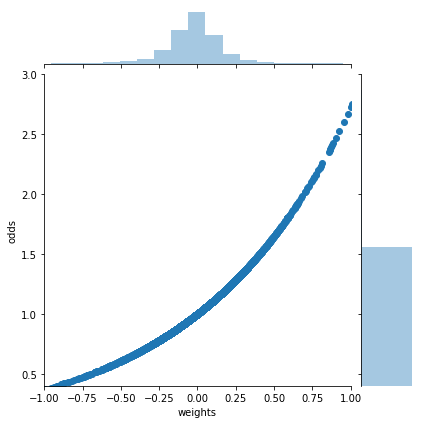

In [42]:
sns.jointplot(x="weights", y="odds", ylim= [0.4, 3], xlim = [-1, 1], data=coef_10k)

As we can see, the weights and odds relationship does look mostly linear. We limit our x-axis between -1.0 and 1.0 as majority of the weights fall within this range.


#### 5.4.1.3 Multicollinearity
This is an important assumption, as we must insure that our independent variables do not have high correlation. If they are, we would need to remove variables that would violate this assumption. In the EDA section, we showed a our correlation heat map which did not indicate any two variables having collinearity, thus proving that this assumption has been met.

#### 5.4.1.4 Independent errors

(Reference: https://wiki.q-researchsoftware.com/wiki/Regression_-_Diagnostic_-_Serial_Correlation_(Durbin-Watson))

Another assumption of logistic regression is the independence of errors. This means that we should not see correlation between errors of two observations. This assumption exists to avoid matching assumptions, which may happen due to clustering of data. To meet this assumption, we run a Durbin Watson test, which tests the first-order autocorrelation of the residuals. The null hypothesis is that there is no autocorrelation. A DW value between 1.5 and 2.5 confirms that there is no first-order autocorrelation. 

In [8]:
# Read results, calculate residuals, calculate durbin watson statistic

ohe10k = pd.read_csv('./logistic_regression/results/predictions_10k_ohe.csv', index_col=None)
ohe10k.columns = ['label', 'pred', 'logloss']
residuals = ohe10k['label'].sub(ohe10k['pred'], axis = 0) 
print("Durbin Watson Stat = " + str(round(durbin_watson(residuals), 2)))

Durbin Watson Stat = 0.9


The DW value we see is 0.9, which is slightly lower than the threshold to confirm the lack of autocorrelation. However, given that it is only slightly lower than the required value, and the fact that we have met the other assumptions, we can live with it.

### 5.4.2 Feature Assumptions

(Reference: https://www.dropbox.com/s/2n8uekjwpaur3bj/Deep-Learning-for-Criteo-Documentation.pdf?dl=0)

When dealing with a large dataset, with high dimmensionality and features that are both numerical and catagorical, it is essential to start by observing the data, laying out a plan, and figuring out what assumptions need to be made to balance accuracy and complexity of the model. In our initial data explorations, we realized that if we planned on one-hot-encoding our features, we would quickly fall into the curse of dimmensionality, as most of our 39 features contained thousands of unique values. We took the approach referenced in de Wit's paper above, where for each feature, we identified values that contained less than $\tau$ unique occurences in the specific column, where $\tau$ was our threshold, and lumped them into a "stash" group. Each column had its own stash value, and we repeated this process at different thresholds, once at 10,000 occurences, and once at 3,000.

By carrying out this process, we made an implicit assumption that the stashed variables would be insignificant and thus could be lumped together and stashed. This assumption would be satisfied if we were able to prove that the stashed coefficients had little effect on our model, which we were able to do when we plotted the coefficients in section 4.2.5. Plotting the coefficients, we observed that the stashed coefficients were indeed huddled around 0, which validated our assumption that they would not have a significant effect on our model.

While the 10K plot in 4.2.5 showed _all_ of these stashed coefficients were at or around zero, the 3K plot showed some deviation, implying that some of these variables may indeed be important. This meant that by lowering the threshold, some of the stashed variables we exposed that some of our features did have importance in the remaining stashed variables, which lead us to believe that in future work, we should look to established custom thersholds for each model, rather than one threshold for all features. This would allow us to model with a higher degree of assurance that our assumption is robust and will not be easily violated.